# Pipeline for Question Answering -  ESG Assessment Projects BNP

### PARTIE CODE -------------------------------------------------------------------------------------------------

Loading all our nlp models ! (property of BNP Paribas Risk Air Team)

In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [18]:
import json
import os
import re
import sys
import uuid
import prettytable
import time
import cProfile
import re

import pandas as pd
import numpy as np
import tinyarray
import nltk
import torch

""" If you never installed punkt and wordnet:
nltk.download('punkt') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
!python -m textblob.download_corpora
!python -m spacy download en

"""
import torch.nn as nn
import tensorflow as tf #for tfrecordfiles
from tqdm import tqdm
from tika import parser
from nltk import tokenize as tkn
from string import digits
from nltk import pos_tag, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as skf
from sklearn.base import BaseEstimator
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob
from data.Infersent.model import InferSent
import enchant
from sentence_transformers import SentenceTransformer

from sklearn import decomposition
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import spherecluster
from sklearn import decomposition
from sklearn import datasets

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/Users/williamlambert/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [15]:
flags = tf.flags

FLAGS = flags.FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)


flags.DEFINE_integer(
    "model",5,
    """** Select a model \n 
        **Model without pre-clustering: \n
        \t 1-Infersent_glove [Pretrained] (10 min/corpus) \n
        \t 2-Bert [Pretrained on SQUAD] (30 min/corpus) \n
        \t 3-Tf_Idf_Lemmatizer [Trained on our corpus] (5 min/ corpus) \n
        
         **Model with pre-clustering\n
        \t 4-Tf-Idf_Bert [Pretrained on SQuAD] (3 min/query)\n
        \t 5-Tf-Idf_Bert_enhanced [Finetuned on MsMarco] (1:30 min/query)\n
        \t 6- All \n
        
        The settings of our test was : CPU, 15 queries, size_cluster=50, corpus of 1500 sentences / 300 pages
        and a domain_vocab of 3000 sentences / 600 pages \n
        The timespeed of pdf converter is approximately 10s/1000 pages
        The best results were achieved with model 5""" )

flags.DEFINE_boolean(
    "demo",False,
    "Demo mode with your own pdfs")


flags.DEFINE_integer(
    "size_cluster",35,
    "size of the clusters of candidate to feed in neural network.")

flags.DEFINE_string(
    "domain",None,
    "Domain folder name to process Q&A")

flags.DEFINE_string(
    "retrieved_company",None,
    "Company folder name to query")

flags.DEFINE_string(
    "pdf_directory",'../harshQA-master/utils/pdf_files/',
    "Path of the pdf directory")

flags.DEFINE_string(
    "output_folder",'./output/tfrecord',
    "Path to save the tf records ")

flags.DEFINE_string(
    "vocab_file",
    "./data/bert/pretrained_models/uncased_L-12_H-768_A-12/vocab.txt",
    "The vocabulary file that the BERT model was trained on.")

flags.DEFINE_string(
    "infersent_path",
    "dataset/fastText/crawl-300d-2M.vec",
    "Path of the .vec file of GloVe or FastText")

flags.DEFINE_string(
    "infersent_model",
    "dataset/encoder/infersent2.pkl",
    "Path of the .pkl file of infersent model")

flags.DEFINE_string(
    "w2v_path",None,
    "Path of .txt file containing glove model.")

flags.DEFINE_string(
    "model_path",None,
    "Path of the .pkl file containing infersent model.")
    

flags.DEFINE_integer(
    "max_seq_length", 512,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "max_query_length", 128,
    "The maximum query sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated.")
    
flags.DEFINE_integer(
    "top_n",5,
    "Number of doc to retrieve per query")

flags.DEFINE_boolean(
    "bigram",False,
    "Wether to use bigram on unigram as langage models, we advise to set it to False")
    
flags.DEFINE_float(
    "threshold",0.00,
    "Threshold of similarity to apply (not advised)")


In [16]:
## Required parameters
flags.DEFINE_string(
    "data_dir", None,
    "The input data dir. Should contain the .tfrecord files and the supporting "
    "query-docids mapping files.")

flags.DEFINE_string(
    "bert_config_file", "./data/bert_msmarco/bert_config.json",
    "The config json file corresponding to the pre-trained BERT model. "
    "This specifies the model architecture.")

flags.DEFINE_boolean(
    "msmarco_output", True,
    "Whether to write the predictions to a MS-MARCO-formatted file.")

flags.DEFINE_string(
    "init_checkpoint",
    "./data/bert_msmarco/model.ckpt",
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_bool("do_train", False, "Whether to run training.")

flags.DEFINE_bool("do_eval", True, "Whether to run eval on the dev set.")

flags.DEFINE_integer("train_batch_size", 35, "Total batch size for training.")

flags.DEFINE_integer("eval_batch_size", 35, "Total batch size for eval.")
#32 former settings
flags.DEFINE_float("learning_rate", 1e-6, "The initial learning rate for Adam.")

flags.DEFINE_integer("num_train_steps", 400000,
                     "Total number of training steps to perform.")

flags.DEFINE_integer("max_eval_examples", None,
                     "Maximum number of examples to be evaluated.")

flags.DEFINE_integer(
    "num_warmup_steps", 40000,
    "Number of training steps to perform linear learning rate warmup.")

flags.DEFINE_integer("save_checkpoints_steps", 100,
                     "How often to save the model checkpoint.")

flags.DEFINE_integer("iterations_per_loop", 1,
                     "How many steps to make in each estimator call.")

flags.DEFINE_bool("use_tpu", False, "Whether to use TPU or GPU/CPU.")

tf.flags.DEFINE_string(
    "tpu_name", None,
    "The Cloud TPU to use for training. This should be either the name "
    "used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 "
    "url.")

tf.flags.DEFINE_string(
    "tpu_zone", None,
    "[Optional] GCE zone where the Cloud TPU is located in. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

tf.flags.DEFINE_string(
    "gcp_project", None,
    "[Optional] Project name for the Cloud TPU-enabled project. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

tf.flags.DEFINE_string("master", None, "[Optional] TensorFlow master URL.")

flags.DEFINE_integer(
    "num_tpu_cores", 8,
    "Only used if `use_tpu` is True. Total number of TPU cores to use.")

# Code dependencies of the project

In [22]:
#Code implemented: 
%run QA_pdf_reader/reader.ipynb
%run QA_sota_retrievers/Tf_Idf.ipynb
%run QA_sota_retrievers/Tf_Idf_Farahat_Bert.ipynb
%run utils/generate_squad_examples.ipynb

#Libraries Bert,Infersent
%run QA_sota_retrievers/Bert.ipynb
%run QA_sota_retrievers/Infersent.ipynb

#dl4marco-bert-master folder for Bert finetuning
%run QA_neural_reranker/tfrecord_QA 
%run dl4marco-bert-master/tokenization 
%run dl4marco-bert-master/metrics
%run dl4marco-bert-master/modeling
%run dl4marco-bert-master/optimization
#%run dl4marco-bert-master/run_msmarcoQA

## Main__

In [72]:
%%time


"""
        **Models implemented
        
        ** Model without pre-clustering:
        1-Infersent_glove [Pretrained] (10 min/corpus)
        2-Bert [Pretrained on SQUAD] (30 min/corpus)
        3-Tf_Idf_Lemmatizer [Trained on our corpus] (5 min/ corpus)
        
        **Model with pre-clustering
        4-Tf-Idf_Bert [Pretrained on SQuAD] (3 min/query)
        5-Tf-Idf_Bert_enhanced [Finetuned on MsMarco] (1:30 min/query)
        6- All
        
        The settings of our test was : CPU, 15 queries, size_cluster=50, corpus of 1500 sentences / 300 pages
        and a domain_vocab of 3000 sentences / 600 pages
        The timespeed of pdf converter is approximately 10s/1000 pages
        The best results were achieved with model 5
"""

demo=False
model=5
size_cluster=30
max_seq_length=512
max_query_length=128

retrieved_company='Mariott'
domain='Tourism'

pdf_directory='../harshQA-master/utils/pdf_files/'
output_folder='./harshQA-master/output/tfrecord'
vocab_file="./data/bert/pretrained_models/uncased_L-12_H-768_A-12/vocab.txt"
infersent_path='dataset/fastText/crawl-300d-2M.vec'
infersent_model='dataset/encoder/infersent2.pkl'

main()

************ READER *************
Reading pdfs doc on location:  ../question_answering/pdf_files/Tourism/Mariott/pdfs/
files from ../question_answering/pdf_files/Tourism/Mariott/pdfs succesfully converted 
files from ../question_answering/pdf_files/Tourism/Domain_vocab/other_annual_reports succesfully converted 
files from ../question_answering/pdf_files/Tourism/Domain_vocab/specific_vocab succesfully converted 
********* DOCUMENTS RETRIEVED **********
FOLDER : Mariott , 1808 sentences
FOLDER : Domain_vocab , 4038 sentences
FOLDER : Similar reports , 2109 sentences
********* MODEL BERT FINETUNED & TFIDF SHORT TEXT CLUSTERING **********
Vocab size : 500000
beginning of tf_idf fit


/Users/williamlambert/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


end of tf_idf fit
beginning of tf_idf bert (finetuned) fit
begin of term selection
begin of generate kernel
end of generate kernel
end of tf_idf bert (finetuned) fit
beginning of tf_idf bert (finetuned) predict
Converting eval set to tfrecord...
Done!


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1013 22:02:50.934985 4492907968 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not li

W1013 22:02:51.448460 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d1090b8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d1090b8>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:02:51.583057 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d17c080>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d17c080>

W1013 22:02:52.776479 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d0f4ef0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d0f4ef0>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:02:52.934324 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d1624a8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d1624a8>

W1013 22:02:53.949076 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d162b00>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d162b00>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:02:54.116959 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d4ad9b0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d4ad9b0>

W1013 22:02:55.147912 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d6497b8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d6497b8>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:02:55.280854 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d60aeb8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d60aeb8>

W1013 22:02:56.348474 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d6b56d8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d6b56d8>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:02:56.505712 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d0f4d30>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d0f4d30>

W1013 22:02:57.617334 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d7f5eb8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d7f5eb8>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:02:57.773618 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d99bb00>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d99bb00>

W1013 22:02:58.820863 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d375550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d375550>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:02:58.957993 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d375550>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d375550>

W1013 22:03:00.028051 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2dc47b70>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2dc47b70>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:03:00.188613 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d3c4ef0>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d3c4ef0>

W1013 22:03:01.243340 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d8810b8>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2d8810b8>>: AssertionError: Bad argument number for Name: 3, expecting 4
W1013 22:03:01.410794 4492907968 ag_logging.py:145] Entity <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2ded6d68>> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: converting <bound method Dense.call of <tensorflow.python.layers.core.Dense object at 0x1c2ded6d68>


W1013 22:03:02.345032 4492907968 deprecation_wrapper.py:119] From dl4marco-bert-master/run_msmarcoQA.py:187: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.

INFO:tensorflow:Done calling model_fn.
I1013 22:03:03.110802 4492907968 estimator.py:1147] Done calling model_fn.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1013 22:03:03.316160 4492907968 deprecation.py:323] From /Users/williamlambert/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
I1013 22:03:03.695300 4492907968 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Running local_init_op.
I1013 22:03:08.036602 4492

# Demonstration: TFIDF Short Text Semantic Clustering + BERT Reranking

In [59]:
#tokenizer = tokenization.FullTokenizer(
      #vocab_file=FLAGS.vocab_file, do_lower_case=True)
tokenizer = FullTokenizer(vocab_file=vocab_file, do_lower_case=True)
query1='Does the company operate outside the european union?'
query2='Is there a commitment plan to reduce greenhouse gas emissions'

docs1=['We used to operate in financial market and leveraging finance',
 'Our company operates with capitalists firms in finance and real estate area',
 'Our company is on the verge of merging with CS corporation located in France',
 'We operate in USA',
       'We operate in Sweden',
 'We travel to European Union and have fun ']

docs2=['We are mainly focus on reducing our energetical costs with a responsible use of carbon',
     'Carbonic emissions are a threat since it jeopardizes several animal species in Kenya',
     'We are fostering a responsible use of new energies in all our sites to reduce global warming through our levels of GHG.',
       'We are fostering a responsible use of new energies in all our sites to reduce global warming',
     'We are committed to strenghten our sites security throughout the world ',
     'The onu environment group has recently revealed energetical scandals on news papers']
docs=[tuple(docs1),tuple(docs2)]
query=[query1,query2]
labels=tuple([0 for i in range(len(docs1))])
doc_ids1=[str(i) for i in range(len(docs1))]
doc_ids2=[str(i) for i in range(len(docs2))]
doc_ids=[doc_ids1,doc_ids2]
query_id=['1','2']

convert_eval_dataset(tokenizer,output_folder,output_folder + '/query_doc_ids_' + 'eval' + '.txt',max_seq_length,max_query_length,query,docs,labels,query_id,doc_ids)

!python answer-reranking/run_msmarcoQA.py \
  --output_dir=dl4marco-bert-master/output/output_QA\
  --data_dir=dl4marco-bert-master/tfrecord \
  --bert_config_file=dl4marco-bert-master/data/bert_msmarco/bert_config.json \
  --init_checkpoint=dl4marco-bert-master/data/bert_msmarco/model.ckpt \
  --max_seq_length=512 \
  --msmarco_output=True \
  --eval_batch_size=6 \
  --num_eval_docs=6 \
  --iterations_per_loop=6

df=pd.read_csv('dl4marco-bert-master/output_QA/msmarco_predictions_eval.tsv',sep='\t',names=['Q_id','Doc_id','Rank','Probs'])
answers_sorted=list(np.array(docs1)[df[df.Q_id==1].Doc_id.tolist()])+list(np.array(docs2)[df[df.Q_id==2].Doc_id.tolist()])
df['Answer']=answers_sorted
df['Query']=[query1]*6+[query2]*6
df[['Query','Answer','Rank','Probs']]

Converting eval set to tfrecord...
Done!
^C
Traceback (most recent call last):
  File "dl4marco-bert-master/run_msmarcoQA.py", line 11, in <module>
    import tensorflow as tf
  File "/Users/williamlambert/anaconda3/lib/python3.7/site-packages/tensorflow/__init__.py", line 28, in <module>
    from tensorflow.python import pywrap_tensorflow  # pylint: disable=unused-import
  File "/Users/williamlambert/anaconda3/lib/python3.7/site-packages/tensorflow/python/__init__.py", line 63, in <module>
    from tensorflow.python.framework.framework_lib import *  # pylint: disable=redefined-builtin
  File "/Users/williamlambert/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/framework_lib.py", line 52, in <module>
    from tensorflow.python.framework.importer import import_graph_def
  File "/Users/williamlambert/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/importer.py", line 28, in <module>
    from tensorflow.python.framework import function
  File "/Users/wi

,Query,Answer,Rank,Probs
0,Does the company operate outside the european union?,We operate in Sweden,1,0.031970
1,Does the company operate outside the european union?,We operate in USA,2,0.011579
2,Does the company operate outside the european union?,Our company is on the verge of merging with CS corporation located in France,3,0.003270
3,Does the company operate outside the european union?,We travel to European Union and have fun,4,0.001812
4,Does the company operate outside the european union?,Our company operates with capitalists firms in finance and real estate area,5,0.000750
5,Does the company operate outside the european union?,We used to operate in financial market and leveraging finance,6,0.000398
6,Is there a commitment plan to reduce greenhouse gas emissions,We are fostering a responsible use of new energies in all our sites to reduce global warming through our levels of GHG.,1,0.004618
7,Is there a commitment plan to reduce greenhouse gas emissions,We are fostering a responsible use of new energies in all our sites to reduce global warming,2,0.004548
8,Is there a commitment plan to reduce greenhouse gas emissions,We are mainly focus on reducing our energetical costs with a responsible use of carbon,3,0.002039
9,Is there a commitment plan to reduce greenhouse gas emissions,The onu environment group has recently revealed energetical scandals on news papers,4,0.000662


### 1)  Pdf Retriever (using Tika & Enchant / np.vectorize for faster performance)

In [4]:
class pdfconverter():
    def __init__(self,directory_path=None):
        global domain
        global retrieved_company
        directory_path=pdf_directory+domain+'/'
        
        self.english_voc=enchant.Dict("en_US")
        self.text_processor_pdf=np.vectorize(self.text_preprocessing_pdf,otypes=[str])
        self.df = pd.DataFrame(columns=['pdf','directory','directory_index','raw paragraphs','paragraphs'])
        self.parser=[]
        self.parser_raw=[]
        self.directory_path=directory_path

        self.list_folder=[]
        self.paths={}
        directories=[directory_path+retrieved_company, directory_path+'Domain_vocab']
        for dirs in directories:
            for r,d,f in os.walk(dirs):
                if d==[] and 'pdf' in '.'.join(f):
                    self.list_folder.append(r)

            for folder in self.list_folder:
                for i,pdf in enumerate(os.listdir(folder)):
                    if pdf!= '.DS_Store':
                        self.paths[folder]=self.paths.get(folder,[])+[(i,pdf)]
        
    def transform(self):
        print('************ READER *************')
        print("Reading pdfs doc on location: ",pdf_directory+domain+'/'+retrieved_company+'/pdfs/')
        """Pdf-files reader with Apache Tika"""
        count=1
        for i,folder in enumerate(self.list_folder):
            path=folder
            for j,pdf in enumerate(os.listdir(path)):
                if pdf!= '.DS_Store':
                    self.df.loc[count] = [pdf,folder.split('/')[-2], i+1,None,None]
                    
                    """ 0- Read Pdf file """
                    raw = parser.from_file(os.path.join(path,pdf))
                    s = raw['content']
                    
                    """ 1- Handle linebreaks to optimize TextBlob.sentences results"""
                    s=self.treat_new_line(s)
                    
                    """ 2- Divide text by sentences using TextBlob"""
                    blob=TextBlob(s)
                    paragraphs = np.array([str(s) for s in blob.sentences],dtype=str)
                    self.parser = []
                    self.parser_raw=[]
                    p=self.text_processor_pdf(paragraphs)
                    
                    """
                    3- Get rid of bad text data:
                    Discard sentences with too long word (16 is the 99% quantile in english)
                    Discard sentences with too much upper words (CREDENTIALS, Link, TITLE ..)
                    """
                    index_=[i for i,c in enumerate(self.parser) if (True in [len(w)>=16 for w in c.split()] )]
                    index_raw=[i for i,c in enumerate(self.parser_raw) if np.sum([w==w.upper() for w in c.split()])>=4]
                    index=list(set(index_ + index_raw))
                    self.df.loc[count,'paragraphs']=np.delete(np.array(self.parser),index)
                    self.df.loc[count,'raw paragraphs']=np.delete(np.array(self.parser_raw),index)
                    count+=1
                            
            print("files from {} succesfully converted ".format(folder))
                
        return self.df
    
    def remove_non_alpha(self,text):
        
        """ Remove non alpha-decimal caracters that are not dot or linebreaker """
        
        removelist="-\.\/\?"
        re_alpha_numeric1=r"[^0-9a-zA-Z"+removelist+" ]"
        clean_text=re.sub(re_alpha_numeric1,'',text)
        clean_text=clean_text.replace('/',' ')
        clean_text=re.sub(' +', ' ', clean_text)
        return clean_text
    
    def treat_new_line(self,text):
        """ 
        This function is aimed to deal with all types of linebreaks we met during our tests 
        There is linebreaks dure to cut-sentences, cut-words, bullet-list, title, new paragraphs, or sentences breaks
        """
        text=text.replace('.\n','. ')
        text=re.sub(r'(\n\s*)+\n+', '\n\n',text )
        
        lw=text.split('\n\n')
        lw=[c for c in lw if c.replace(' ','')!='']
            
        for i in range(1,len(lw)):
            try:

                el=lw[i]
                if len(el)>=1:
                    try:
                        first_w=el.split()[0]
                    except:
                        first_w=el
                    first_l=first_w[0]
                    if first_l.isupper() :
                        if len(lw[i-1])>0 and lw[i-1].replace(' ','') !='':
                            if lw[i-1].replace(' ','')[-1] not in [":",'.',"-",'/',"'",";"]:
                                prec=lw[i-1].split(".")[-1]
                                merge=(prec+' '+lw[i]).split()
                                dic=dict(nltk.tag.pos_tag(merge))
                                proper_noun=dic[first_w]=='NNP'
                                if not proper_noun:
                                    if not "." in lw[i-1]:
                                        lw[i-1]=lw[i-1]+".\n\n "
                                    else:
                                        lw[i-1]=lw[i-1][:-1]+".\n\n "
                                else:
                                    lw[i-1]+=' '


                    elif first_l.islower():
                        if len(lw[i-1])>0 and lw[i-1][-1].replace(' ','')!='':

                            if lw[i-1][-1].replace(' ','')[-1]!='-':
                                lw[i-1]+=""
                            else:

                                ltemp_prev=lw[i-1].split(' ')
                                ltemp_next=lw[i].split(' ')
                                motprev=ltemp_prev[-1][:-1]
                                motnext=lw[i].split(' ')[0]
                                if len((motprev+' '+motnext).split())==2:

                                    if self.english_voc.check(motprev) and self.english_voc.check(motnext) and not self.english_voc.check("".join([motprev,motnext])) :
                                        newmot=" ".join([motprev,motnext])
                                    else:
                                        newmot="".join([motprev,motnext])
                                    ltemp_prev[-1]=newmot
                                    ltemp_next[0]=""
                                    lw[i-1]=" ".join(ltemp_prev)
                                    lw[i]=" ".join(ltemp_next)
                    else:
                        lw[i-1]+="\n\n"
            
            except:
                print('Error occurs, the reader may not be suitable for your pdf files')
            
            
        text="".join(lw)
        
        lw=text.split('\n')
        lw=[c for c in lw if c.replace(' ','')!='']
        for i in range(1,len(lw)):
            try:
                el=lw[i]
                if len(el)>=1:
                    try:
                        first_w=el.split()[0]
                    except:
                        first_w=el
                    first_l=first_w[0]
                    if first_l.isupper() :
                        if len(lw[i-1])>0 and lw[i-1].replace(' ','')!='':
                            if lw[i-1].replace(' ','')[-1] not in [":",'.',"-",'/',"'",";"]:
                                prec=lw[i-1].split(".")[-1]
                                merge=(prec+' '+lw[i]).split()
                                dic=dict(nltk.tag.pos_tag(merge))
                                proper_noun=dic[first_w]=='NNP'
                                if not proper_noun:
                                    if not "." in lw[i-1]:
                                        lw[i-1]=lw[i-1]+".\n\n "
                                    else:
                                        lw[i-1]=lw[i-1][:-1]+".\n\n "
                                else:
                                    lw[i-1]+=' '
                    elif first_l.islower():
                        if len(lw[i-1])>0 and lw[i-1].replace(' ','')!='':
                            if lw[i-1].replace(' ','')[-1]=="-":
                                ltemp_prev=lw[i-1].split(' ')
                                ltemp_next=lw[i].split(' ')
                                motprev=ltemp_prev[-1][:-1]
                                motnext=lw[i].split(' ')[0]
                                if len((motprev+' '+motnext).split())==2:
                                    if self.english_voc.check(motprev) and self.english_voc.check(motnext) and not self.english_voc.check("".join([motprev,motnext])) :
                                        newmot=" ".join([motprev,motnext])
                                    else:
                                        newmot="".join([motprev,motnext])
                                    ltemp_prev[-1]=newmot
                                    ltemp_next[0]=""
                                    lw[i-1]=" ".join(ltemp_prev)
                                    lw[i]=" ".join(ltemp_next)



                            else:
                                lw[i-1]+=" "
                    else:
                        lw[i-1]+=" "
        
            except:
                print('Error occurs, the reader may not be suitable for your pdf files')
        
        text="".join(lw)
        return text
    
    """
    def remove_end_paragraphs(self,p):
        if '-\n' in p:
            paraph=[]
            ltemp=p.split(' ')
            for mot in ltemp:
                if '-\n' in mot:
                    if len(mot.replace('-\n',' ').split())==2:
                        mot1,mot2=mot.replace('-\n',' ').split()
                        if self.english_voc.check(mot1) and self.english_voc.check(mot2) and not self.english_voc.check("".join([mot1,mot2])) :
                            newmot=" ".join([mot1,mot2])
                        else:
                            newmot="".join([mot1,mot2])
                        paraph.append(newmot)
                else:
                    paraph.append(mot)
            p=" ".join(paraph)
        return p.replace('\n',' ')
    """
    
    def cut_text(self,p):
        
        """ Cut text into sentences """
        if "?" not in p and len(p)>=100:
            
            phrases=self.remove_non_alpha(p)    
            phrases=phrases.replace('.',' ')
            phrases=phrases.replace('-',' ')
            phrases=phrases.replace("?"," ")
            phrases=re.sub(' +', ' ', phrases)
            phrases=re.sub(r'([0-9]+(?=[a-z])|(?<=[a-z])[0-9]+)',"",phrases)
            phrases=phrases.lower()
            self.parser.append(re.sub(' +', ' ', phrases))
            
        return None 
    
    def cut_text_raw(self,p):
        """Cut raw/untreated text into sentences """
        
        if "?" not in p and len(self.remove_non_alpha(p))>=100:
            self.parser_raw.append(re.sub(' +', ' ', p))
            
        return None
    
    def text_preprocessing_pdf(self,p):
        """ Pipeline of sentences-preprocessing using np.vectorize for faster results """
        #remover_end_paragraphs=np.vectorize(self.remove_end_paragraphs,otypes=[str])
        cleaner=np.vectorize(self.remove_non_alpha,otypes=[str])
        cut_text=np.vectorize(self.cut_text,otypes=[str])
        cut_text_raw=np.vectorize(self.cut_text_raw,otypes=[str])
        cut_text_raw(p)
        p=cleaner(p)
        cut_text(p)
        return p


    
    



### 2) Tf Idf search ranking retriever with Porter-Stemming, Cosine Similarity and n-grams

In [5]:
class m3_Tfidf(BaseEstimator):
    """
    A scikit-learn wrapper for TfidfRetriever. Trains a tf-idf matrix from a corpus
    of documents then finds the most N similar documents of a given input document by
    taking the dot product of the vectorized input document and the trained tf-idf matrix.
    
    Parameters
    ----------
    ngram_range : bool, optional
        [shape of ngram used to build vocab] (the default is False)
    max_df : bool, optional
        [while building vocab delete words that have a frequency>max_df] (the default is False)
    stop_words : str, optional
        ['english is the only value accepted'] (the default is False)
    paragraphs : iterable
        an iterable which yields either str, unicode or file objects
    top_n : int
        maximum number of top articles to retrieve
        header should be of format: title, paragraphs.
    verbose : bool, optional
        If true, all of the warnings related to data processing will be printed.
    Attributes
    ----------
    vectorizer : TfidfVectorizer
        See https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    tfidf_matrix : sparse matrix, [n_samples, n_features]
        Tf-idf-weighted document-term matrix.
        
    Examples
    --------
    >>> retriever = TfidfRetriever(ngram_range=(1, 2), max_df=0.85, stop_words='english')
    >>> retriever.fit(X=df['content'])
    
    >>> doc_index=int(input('Which document do you want to use for your question?'))
    >>> retriever.transform(X=df.loc[doc_index,'content'])
    
    >>> Q=str(input('Enter your question'))
    >>> Q=retriever.vectorizer.transform([Q])
    >>> closest_docs,scores = self.retriever.predict(newQst,df.loc[doc_index,'content'])
    """

    def __init__(self,
                 ngram_range=(1, 2),
                 max_df=0.85,
                 stop_words='english',
                 paragraphs=None,
                 verbose=False, top_n=5,
                lemmatize=False,
                transform_text=True):

        self.ngram_range = (1,1)
        self.max_df = max_df
        self.stop_words = stop_words
        self.paragraphs = paragraphs
        self.top_n = top_n
        self.verbose = verbose
        self.transform_text=transform_text
        self.lemmatize=lemmatize and self.transform_text
        self.stem=not lemmatize and self.transform_text
        if self.stem: self.stemmer=PorterStemmer()
        else: self.lemmatizer=WordNetLemmatizer() 
        self.stop_words_list=[self.tokenize(word)[0] for word in list(skf._check_stop_list('english'))]

    def stem_tokens(self,tokens, stemmer):
        stemmed = []
        for item in tokens:
            stemmed.append(stemmer.stem(item))
        return stemmed
    
    def lemmatize_tokens(self,tokens,lemmatizer):
        lemmas=[]
        for item in tokens:
            for word, tag in pos_tag(word_tokenize(item)):
                wntag = tag[0].lower()
                wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
                if not wntag:
                    lemma = word
                else:
                    lemma = lemmatizer.lemmatize(word, wntag)
            
            lemmas.append(lemma)
        return lemmas

        """
        for item in tokens:
            lemmas.append(lemmatizer.lemmatize(item))
        return lemmas
        """

    def tokenize(self,text):
        tokens = nltk.word_tokenize(text)
        if self.lemmatize:
        #stems = self.stem_tokens(tokens, self.stemmer)
            lemmas=self.lemmatize_tokens(tokens,self.lemmatizer)
            return lemmas
        elif self.stem:
            stems = self.stem_tokens(tokens, self.stemmer)
            return stems
        else:
            return tokens
        
        
    def fit(self, X, y=None): #generate features and return tfidf scores matrix 

        self.vectorizer = TfidfVectorizer(ngram_range=self.ngram_range,
                                          max_df=self.max_df,
                                   stop_words=self.stop_words_list,tokenizer=self.tokenize)
        self.vectorizer.fit(X)
        return self
    
    def transform(self,X,y=None):
        self.tfidf_matrix=self.vectorizer.transform(X)
        return self
    
    def predict(self, X, metadata):
        tfidf_matrix=self.tfidf_matrix[metadata[0]:metadata[1],:]
        #cherche les querries les plus proches de chaque sentence
        t0 = time.time()
        question_vector = self.vectorizer.transform([X])
        scores = pd.DataFrame(tfidf_matrix.dot(question_vector.T).toarray())
        closest_docs_indices = scores.sort_values(by=0, ascending=False).index[:self.top_n].values

        # inspired from https://github.com/facebookresearch/DrQA/blob/50d0e49bb77fe0c6e881efb4b6fe2e61d3f92509/scripts/reader/interactive.py#L63
        if self.verbose:
            rank = 1
            table = prettytable.PrettyTable(['rank', 'index', 'title'])
            for i in range(len(closest_docs_indices)):
                index = closest_docs_indices[i]
                if self.paragraphs:
                    article_index = self.paragraphs[int(index)]['index']
                    title = metadata.iloc[int(article_index)]['title']
                else:
                    title = metadata.iloc[int(index)]['title']
                table.add_row([rank, index, title])
                rank+=1
            print(table)
            print('Time: {} seconds'.format(round(time.time() - t0, 5)))

        return closest_docs_indices,scores

### Infersent search ranking retriever (used Tokenizing and Finetuning for our dataset) + also used PCA to speed-up a bit 

In [6]:
class m1_Infersent(BaseEstimator):
    """
    A scikit-learn estimator for TfidfRetriever. Trains a tf-idf matrix from a corpus
    of documents then finds the most N similar documents of a given input document by
    taking the dot product of the vectorized input document and the trained tf-idf matrix.
    
    Parameters
    ----------
    Ktop_words: int
        number of words used for sentence embeddings (the K most frequent english words - 
        for more information see Infersent repository.)
    paragraphs : iterable
        an iterable which yields either str, unicode or file objects
    top_n : int
        maximum number of top articles to retrieve
        header should be of format: title, paragraphs.
    verbose : bool, optional
        If true, all of the warnings related to data processing will be printed.
    Attributes
    """ 
    def __init__(self,
                 top_n=3,
                Ktop_words=500000,
                sentences=None,
                verbose=False,
                model_path=None, 
                w2v_path=None):
        self.top_n = top_n
        self.verbose = verbose
        self.Ktop_words=Ktop_words
        self.w2v_path=w2v_path
        self.model_path=model_path
        self.kwargs_Infersent = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                        'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
        
        self.infersent = InferSent_(self.kwargs_Infersent)
        self.infersent.load_state_dict(torch.load(self.model_path))
        self.infersent.set_w2v_path(self.w2v_path)
        self.infersent.build_vocab_k_words(K=self.Ktop_words)
        
    def fit(self,X,y=None):
        """ X: any iterable which contains words to finetune vocabulary """
        self.infersent.update_vocab(list([s for s in X ]))
        return self
    
    def transform(self,X,y=None):
        """ X: any iterable which contains sentences to embed """
        
        self.embeddings = self.infersent.encode(list([s for s in X ]),tokenize=True)
        self.embeddings=np.apply_along_axis(lambda v: self.normalize(v), 1,self.embeddings)
        self.pca = decomposition.PCA(n_components=900)
        self.pca.fit(self.embeddings)
        self.embeddings=self.pca.transform(self.embeddings)
        self.reduced_embeddings = np.apply_along_axis(lambda v: self.normalize(v), 1,self.embeddings)
        return self

    def normalize(self,array):
        return array/np.linalg.norm(array)
    
    def predict(self,X,metadata):

        reduced_embeddings=self.reduced_embeddings[metadata[0]:metadata[1],:]
        question=self.infersent.encode([X])
        encoded_question=self.normalize(question)
        transformed_question=self.pca.transform(encoded_question)
        self.reduced_question=self.normalize(transformed_question)
        
        self.data=reduced_embeddings.dot(self.reduced_question.T)
        self.scores_inf=pd.DataFrame(self.data,index=range(len(self.data)))
        self.closest_docs_indices = self.scores_inf.sort_values(by=0, ascending=False).index[:self.top_n].values
        
        return self.closest_docs_indices,self.scores_inf

In [7]:
class m2_Bert(BaseEstimator):
    
    def __init__(self,top_n=5):
        self.top_n = top_n
        self.bert=SentenceTransformer('bert-large-nli-stsb-mean-tokens')
        
    def fit(self,X,y=None):
        """ X: any iterable which contains words to finetune vocabulary """
        return self
    
    def transform(self,X,y=None):
        """ X: any iterable which contains sentences to embed """
        self.embeddings = self.bert.encode(list([s for s in X ]))
        self.reduced_embeddings = np.apply_along_axis(lambda v: self.normalize(v), 1,self.embeddings)
        return self
    
    def normalize(self,array):
        return array/np.linalg.norm(array)
    
    def predict(self,X,metadata):
        
        question=self.bert.encode([X])
        encoded_question=self.normalize(question)
        self.reduced_question=self.normalize(question)
        
        reduced_embeddings=self.reduced_embeddings[metadata[0]:metadata[1],:]
        
        data=reduced_embeddings.dot(self.reduced_question.T)
        self.scores_inf=pd.DataFrame(data,index=range(len(data)))
        closest_docs_indices = self.scores_inf.sort_values(by=0, ascending=False).index[:self.top_n].values
        return closest_docs_indices,self.scores_inf

        

In [9]:
class m4_Clust_BERT(BaseEstimator):
    """
    A scikit-learn estimator for TfidfRetriever. Trains a tf-idf matrix from a corpus
    of documents then finds the most N similar documents of a given input document by
    taking the dot product of the vectorized input document and the trained tf-idf matrix.
    
    Parameters
    ----------
    ngram_range : bool, optional
        [shape of ngram used to build vocab] (the default is False)
    max_df : bool, optional
        [while building vocab delete words that have a frequency>max_df] (the default is False)
    stop_words : str, optional
        ['english is the only value accepted'] (the default is False)
    paragraphs : iterable
        an iterable which yields either str, unicode or file objects
    top_n : int
        maximum number of top articles to retrieve
        header should be of format: title, paragraphs.
    verbose : bool, optional
        If true, all of the warnings related to data processing will be printed.
    Attributes
    ----------
    vectorizer : TfidfVectorizer
        See https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    tfidf_matrix : sparse matrix, [n_samples, n_features]
        Tf-idf-weighted document-term matrix.
        
    Examples
    --------
    >>> retriever = TfidfRetriever(ngram_range=(1, 2), max_df=0.85, stop_words='english')
    >>> retriever.fit(X=df['content'])
    
    >>> doc_index=int(input('Which document do you want to use for your question?'))
    >>> retriever.transform(X=df.loc[doc_index,'content'])
    
    >>> Q=str(input('Enter your question'))
    >>> Q=retriever.vectorizer.transform([Q])
    >>> closest_docs,scores = self.retriever.predict(newQst,df.loc[doc_index,'content'])
    """

    def __init__(self, TF_emb, q_emb, content, content_doc,stemmed_content, vocab, l_querries,l_querries_raw, by_querries=True, top_n=5,threshold_w=0.002, portion_w=1.0,rank=500,verbose=False):

        self.top_n = top_n
        self.verbose = verbose
        self.TF_emb=TF_emb
        self.threshold_importance=threshold_w
        self.prop_w=portion_w
        self.rk=rank
        self.by_querries=by_querries
        self.querries=l_querries.copy() #(dataframe querries with word importance)
        self.querries_raw=l_querries_raw.copy()
        self.content=content
        self.content_doc=content_doc
        self.stemmed_content=stemmed_content
        self.vocab=vocab
        self.dic_emb={}
        self.q_emb=q_emb
    
    def select_term_Naystrom(self,T):

        #T is the Tf-Idf Matrix 
        #s is the fraction of important words that we want to retrieve (s=1.0 generally)
        print('begin of term selection')
        #Retrieve all the stems of tf-idf vocabulary
        terms=self.vocab
        
        #First we remove digits of the terms candidate
        n=int(self.prop_w*len(terms))
        idx_words=[]
        for i,term in enumerate(terms):
            try: float(term)
            except: idx_words.append(i)

        #Secondly we set a threshold to select words that appear at least each p documents

        #Set threshold to select words that appear at least each p documents 
        self.freq_term=np.zeros((len(self.content),len(terms)))
        
        for j,stem in enumerate(self.stemmed_content):
            for i,c in enumerate(terms):
                if c in stem:
                    self.freq_term[j,i]+=1
                    
        self.freq_term_by_doc=np.apply_along_axis(lambda x: np.mean(x),0,self.freq_term)
        ids=np.where(self.freq_term_by_doc>self.threshold_importance )[0]
        idx_words=[ i for i in ids if i in idx_words]


        #Init selection of terms with most correlation 
        if self.prop_w!=1.0:
            prob=np.sum(np.abs(T)>0,axis=0)
            prob=prob/np.sum(prob)
            prob=np.squeeze(prob)
            idx=[]
            m=len(idx_words)

            for i in range(n):

                p=int(np.random.choice(m,1,prob[0]))
                idx.append(int(idx_words[p]))
                prob[idx_words[p]]=0
                prob=prob/np.sum(prob)

            return idx,np.squeeze(T[:,idx])
        
        else:
            idx=idx_words
            self.idx=idx
            return idx,np.squeeze(T[:,idx])
        print('end of term selection')
    
    

    def fit(self, X, y=None): 

        return self

    def transform(self): #generate new enhanced tf-idf-farahat features ( co-occurence weight frequency matrix) 
        
        idx,A=self.select_term_Naystrom(self.TF_emb.toarray())   
        
        #Full rank approximation
        if self.rk==-1:
            self.rk=len(idx)
                
        qemb=self.q_emb
        print('begin of generate kernel ')
        
        X=self.TF_emb.toarray().transpose()
        X=np.c_[X,qemb]

        L=np.eye(X.shape[0])*np.sqrt(X.shape[0])
        L_inv=np.linalg.inv(L)
        G=L_inv@X@X.transpose()@L_inv
        Gs=G[idx,:]
        Gs=Gs[:,idx]
        S,V,D=np.linalg.svd(Gs, full_matrices=True)
        Ssub,Vsub=S[:,:self.rk], np.diag(V)[:self.rk,:self.rk]
        #Ssub,Vsub=S,np.diag(V)
        #G=Ssub@Vsub$Ssub.transpose() but this operation is not necessary, we just need the decomposition of G

        D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V[:self.rk]))
        #D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V))
        W=(((D_sub_inv@Ssub.transpose())@X[idx,:])@(X.transpose()))@X
        self.TF_FARAHAT_emb=np.apply_along_axis(lambda x: x/np.sqrt(np.sum(x**2)), 1,W.transpose())
        print('end of generate kernel')
        return self

    
    

    

    def predict(self,metadata,repo):
        self.content_repo=self.content_doc[repo]
        questions=self.querries['query'].tolist()
        W_=self.TF_FARAHAT_emb
        scores=W_[-len(questions):]@(W_[metadata[0]:metadata[1]].transpose())
        rank=np.apply_along_axis(lambda x:np.argsort(-x),1,scores)
        raw_or_treated=1 #raw text
        
        all_answers=[]
        all_scores=[]
        all_indices=[]
        all_models=[]
        all_ranks=[]
        all_querries=[]
        bert=m2_Bert(top_n=5)
        for question in range(len(questions)):
            cluster_ids=[]
            answers=[]
            answers_raw=[]
            dic_answers={}
            count_answers=1
            #print('*****  Question {} : {} {}'.format(question,questions[question],'********'))
            rk=0
            count=0
            #print('\n----------------\n')
            w_important=[w for w in questions[question].split(" ") if w==w.upper() ]
            #Display best candidates according to clustering
            
            ### Special words retrieval (Tf-Idf search) ###
            if w_important !=[]:
          
                for w in w_important:
                    ll=m3_Tfidf().tokenize(w)
                    #print("w,ll=",w,ll)
                    if ll!=[]:
                        w=ll[0]
                        best_id=[i for i in range(rank.shape[1]) if w in self.content_repo[0][rank[question,i]].split(' ')]
                        if best_id!=[]:
                            id_match=best_id[0]
                            result=self.content_repo[raw_or_treated][rank[question,id_match]]
                            #print('Special Anserw : {}'.format(self.content_repo[raw_or_treated][rank[question,id_match]]))
                            #print('\n----------------\n')


                            all_indices.extend([rank[question,id_match]])
                            all_scores.extend([scores[question,rank[question,id_match]]])
                            all_answers.extend([result])
                            all_ranks.append(rk+1)
                            all_models.append("Tf-Idf- Semantic Kernel- Bert")
                            all_querries.append(self.querries_raw[question])
                            rk+=1
                            count_answers+=1
            
            ###Normal Loop Spherical Kmeans Clustering and Applying Bert encoder###
            #1 Get clusters
            #print('begin retriever from cluster')
            for answ in range(size_cluster):
                while True:
                    answer_raw=self.content_repo[raw_or_treated][rank[question,count]]
                    answer=self.content_repo[1-raw_or_treated][rank[question,count]]
                    dic_answers[answer]=dic_answers.get(answer,0)+1
                    if dic_answers[answer]==1:
                        break
                    cluster_ids.append(metadata[0]+rank[question,count])
                    count+=1
                
                answers.append(answer)
                answers_raw.append(answer_raw)

                #print('Anserw n°{} : {}'.format(count_answers,answer))
                #print('\n----------------\n')
                
            #print('end loop cluster retriever')

            #2) Use Bert encoder inside clusters + cosine similarity retrieval
            Qst=questions[question].lower()
            newQst=pdfconverter().remove_non_alpha(Qst)
            newQst=newQst.replace('.','')

            #print('initiate bert cluster retriever')
            bert.embeddings=[]
            bert.reduced_embeddings=[]
            
            
            #embeddings = bert.transform(list([s for s in answers ]))
            try:
                bert.embeddings = [QAmodel.bert.embeddings[i] for i in cluster_ids]
                bert.reduced_embeddings = np.apply_along_axis(lambda v: bert.normalize(v), 1,bert.embeddings)
            except:
                indices_saved=[i for (i,c) in enumerate(answers) if c in self.dic_emb.keys()]
                print('just saved {} bert encodings'.format(len(indices_saved)))
                indices_new=[i for i in range(len(answers)) if i not in indices_saved ]
                indices_sort=indices_saved+indices_new
                indices_unsort=np.argsort(indices_sort)
                saved_embeddings=np.array([self.dic_emb[answers[i]] for i in indices_saved])
                new_item=[answers[i] for i in indices_new]
                if indices_new!=[]:
                    bert.transform(list(new_item))
                    new_embeddings=bert.reduced_embeddings
                
                for (i,s) in enumerate(new_item):
                    self.dic_emb[s]=new_embeddings[i]
                    
                if indices_saved!=[]:
                    if indices_new==[]:
                        bert.reduced_embeddings=saved_embeddings
                    else:
                        bert.reduced_embeddings=np.r_[saved_embeddings,new_embeddings][indices_unsort]
                
                
                
            
            indices,scores_bert=bert.predict(newQst,[0,len(answers)])
            scores_bert=scores_bert.loc[indices].values[:,0]
            text=[ answers_raw[i] for i in indices]
            for i,c in enumerate(text):
                
                #print('Anserws n° {} : {}'.format(i+1,c))
                #print('\n----------------\n')
                all_ranks.append(rk+1)
                all_models.append("Tf-Idf- Semantic Kernel- Bert")
                all_querries.append(self.querries_raw[question])
                rk+=1
               
            all_answers.extend(text)
            all_scores.extend(scores_bert)
            all_indices.extend(rank[question,:size_cluster][indices])
            #all_indices.extend(np.array(range(len(self.content_repo[0])))[rank[question,:self.top_n]])
            
        return pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers, all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score'])
    
    

In [10]:
class m5_harshQA(BaseEstimator):
    """
    A scikit-learn estimator for TfidfRetriever. Trains a tf-idf matrix from a corpus
    of documents then finds the most N similar documents of a given input document by
    taking the dot product of the vectorized input document and the trained tf-idf matrix.
    
    Parameters
    ----------
    ngram_range : bool, optional
        [shape of ngram used to build vocab] (the default is False)
    max_df : bool, optional
        [while building vocab delete words that have a frequency>max_df] (the default is False)
    stop_words : str, optional
        ['english is the only value accepted'] (the default is False)
    paragraphs : iterable
        an iterable which yields either str, unicode or file objects
    top_n : int
        maximum number of top articles to retrieve
        header should be of format: title, paragraphs.
    verbose : bool, optional
        If true, all of the warnings related to data processing will be printed.
    Attributes
    ----------
    vectorizer : TfidfVectorizer
        See https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    tfidf_matrix : sparse matrix, [n_samples, n_features]
        Tf-idf-weighted document-term matrix.
        
    Examples
    --------
    >>> retriever = TfidfRetriever(ngram_range=(1, 2), max_df=0.85, stop_words='english')
    >>> retriever.fit(X=df['content'])
    
    >>> doc_index=int(input('Which document do you want to use for your question?'))
    >>> retriever.transform(X=df.loc[doc_index,'content'])
    
    >>> Q=str(input('Enter your question'))
    >>> Q=retriever.vectorizer.transform([Q])
    >>> closest_docs,scores = self.retriever.predict(newQst,df.loc[doc_index,'content'])
    """

    def __init__(self, TF_emb, q_emb, content, content_doc,stemmed_content, vocab, l_querries,l_querries_raw, by_querries=True, top_n=5,threshold_w=0.002, portion_w=1.0,rank=500,verbose=False):

        self.top_n = top_n
        self.verbose = verbose
        self.TF_emb=TF_emb
        self.threshold_importance=threshold_w
        self.prop_w=portion_w
        self.rk=rank
        self.by_querries=by_querries
        self.querries=l_querries.copy() #(dataframe querries with word importance)
        self.querries_raw=l_querries_raw.copy()
        self.content=content
        self.content_doc=content_doc
        self.stemmed_content=stemmed_content
        self.vocab=vocab
        self.dic_emb={}
        self.q_emb=q_emb
    
    def select_term_Naystrom(self,T):

        #T is the Tf-Idf Matrix 
        #s is the fraction of important words that we want to retrieve (s=1.0 generally)
        print('begin of term selection')
        #Retrieve all the stems of tf-idf vocabulary
        terms=self.vocab
        
        #First we remove digits of the terms candidate
        n=int(self.prop_w*len(terms))
        idx_words=[]
        for i,term in enumerate(terms):
            try: float(term)
            except: idx_words.append(i)

        #Secondly we set a threshold to select words that appear at least each p documents

        #Set threshold to select words that appear at least each p documents 
        self.freq_term=np.zeros((len(self.content),len(terms)))
        
        for j,stem in enumerate(self.stemmed_content):
            for i,c in enumerate(terms):
                if c in stem:
                    self.freq_term[j,i]+=1
                    
        self.freq_term_by_doc=np.apply_along_axis(lambda x: np.mean(x),0,self.freq_term)
        ids=np.where(self.freq_term_by_doc>self.threshold_importance )[0]
        idx_words=[ i for i in ids if i in idx_words]


        #Init selection of terms with most correlation 
        if self.prop_w!=1.0:
            prob=np.sum(np.abs(T)>0,axis=0)
            prob=prob/np.sum(prob)
            prob=np.squeeze(prob)
            idx=[]
            m=len(idx_words)

            for i in range(n):

                p=int(np.random.choice(m,1,prob[0]))
                idx.append(int(idx_words[p]))
                prob[idx_words[p]]=0
                prob=prob/np.sum(prob)

            return idx,np.squeeze(T[:,idx])
        
        else:
            idx=idx_words
            self.idx=idx
            return idx,np.squeeze(T[:,idx])
        print('end of term selection')
    
    

    def fit(self, X, y=None): 

        return self

    def transform(self): #generate new enhanced tf-idf-farahat features ( co-occurence weight frequency matrix) 
        
        idx,A=self.select_term_Naystrom(self.TF_emb.toarray())   
        
        #Full rank approximation
        if self.rk==-1:
            self.rk=len(idx)
                
        qemb=self.q_emb
        print('begin of generate kernel')
        
        X=self.TF_emb.toarray().transpose()
        X=np.c_[X,qemb]

        L=np.eye(X.shape[0])*np.sqrt(X.shape[0])
        L_inv=np.linalg.inv(L)
        G=L_inv@X@X.transpose()@L_inv
        Gs=G[idx,:]
        Gs=Gs[:,idx]
        S,V,D=np.linalg.svd(Gs, full_matrices=True)
        Ssub,Vsub=S[:,:self.rk], np.diag(V)[:self.rk,:self.rk]
        #Ssub,Vsub=S,np.diag(V)
        #G=Ssub@Vsub$Ssub.transpose() but this operation is not necessary, we just need the decomposition of G

        D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V[:self.rk]))
        #D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V))
        W=(((D_sub_inv@Ssub.transpose())@X[idx,:])@(X.transpose()))@X
        self.TF_FARAHAT_emb=np.apply_along_axis(lambda x: x/np.sqrt(np.sum(x**2)), 1,W.transpose())
        print('end of generate kernel')
        return self

    def predict(self,metadata,repo):
        
        self.content_repo=self.content_doc[repo]
        questions=self.querries['query'].tolist()
        W_=self.TF_FARAHAT_emb
        scores=W_[-len(questions):]@(W_[metadata[0]:metadata[1]].transpose())
        rank=np.apply_along_axis(lambda x:np.argsort(-x),1,scores)
        raw_or_treated=1 #raw text
        
        
        all_answers=[]
        all_scores=[]
        all_indices=[]
        all_models=[]
        all_ranks=[]
        all_querries=[]
        self.all_answers_retrieved_raw=[]
        self.all_answers_retrieved=[]
        all_querries_treated=[]
        all_question_ids=[]
        special_answer=np.zeros_like(questions,dtype=int)
        
        
        bert=m2_Bert(top_n=5)
        for question in range(len(questions)):
            cluster_ids=[]
            answers=[]
            answers_raw=[]
            dic_answers={}
            count_answers=1
            #print('*****  Question {} : {} {}'.format(question,questions[question],'********'))
            rk=0
            count=0
            #print('\n----------------\n')
            w_important=[w for w in questions[question].split(" ") if (w==w.upper() and len(w)>1) ]
            #print('Important words=',w_important,rank.shape[1])
            #Display best candidates according to clustering
            
            ### Special words retrieval (Tf-Idf search) ###
            if w_important !=[]:
                for w in w_important:
                    try:
                        w=m3_Tfidf(transform_text=False).tokenize(w)[0]
                        w=w.lower()
                        best_id=[i for i in range(rank.shape[1]) if w in self.content_repo[0][rank[question,i]].split(' ')]
                    except:
                        print("an error occured with the important word{}".format(word))
                    
                    #print(",best_id",w,best_id)
                    if best_id!=[]:
                        id_match=best_id[0]
                        result=self.content_repo[raw_or_treated][rank[question,id_match]]
                        #print('Special Anserw : {}'.format(self.content_repo[raw_or_treated][rank[question,id_match]]))
                        #print('\n----------------\n')

                        all_question_ids.extend([question])
                        all_indices.extend([rank[question,id_match]])
                        all_scores.extend([scores[question,rank[question,id_match]]])
                        all_answers.extend([result])
                        all_ranks.append(rk+1)
                        all_models.append("Tf_Idf_Cluster_Bert_Finetuned_MsMarco")
                        all_querries.append(self.querries_raw[question])
                        rk+=1
                        special_answer[question]+=1
                        count_answers+=1
            
            ###Normal Loop Spherical Kmeans Clustering and Applying Bert encoder###
            #1 Get clusters
            #print('begin loop cluster retriever')
            for answ in range(size_cluster):
                while True:
                    answer_raw=self.content_repo[raw_or_treated][rank[question,count]]
                    answer=self.content_repo[1-raw_or_treated][rank[question,count]]
                    dic_answers[answer]=dic_answers.get(answer,0)+1
                    if dic_answers[answer]==1:
                        break
                    cluster_ids.append(metadata[0]+rank[question,count])
                    count+=1
                
                answers.append(answer)
                answers_raw.append(answer_raw)

                #print('Anserw n°{} : {}'.format(count_answers,answer))
                #print('\n----------------\n')
            self.all_answers_retrieved.append(answers)
            self.all_answers_retrieved_raw.append(answers_raw)
            
            #print('end loop cluster retriever')

            #2) Use Bert encoder inside clusters + cosine similarity retrieval
            Qst=questions[question].lower()
            newQst=pdfconverter().remove_non_alpha(Qst)
            newQst=newQst.replace('.','')
            all_querries_treated.append(newQst)
            
        #Prediction with tensorflow app using bert finetuned on re-ranking MsMarco dataset
        
        o=len(all_querries_treated)
        tokenizer = FullTokenizer(vocab_file=vocab_file, do_lower_case=True)
        docs=[tuple(array) for array in self.all_answers_retrieved]
        query_id=[str(i) for i in range(o)]
        doc_ids=[tuple(array) for array in list(np.tile([str(i) for i in range(size_cluster) ],o).reshape(o,-1))]
        labels=[0 for i in range(size_cluster)]
        
        
        global max_query_length
        global output_folder
        
        convert_eval_dataset(tokenizer,
                             output_folder,
                             output_folder + '/query_doc_ids_' + 'eval' + '.txt',
                             max_seq_length,
                             max_query_length,
                             all_querries_treated,
                             docs,
                             labels,
                             query_id,
                             doc_ids)
        
        #print('begin reranking prediction with bert class')       
        
        ! python dl4marco-bert-master/run_msmarcoQA.py \
          --output_dir=dl4marco-bert-master/output_QA\
          --data_dir=dl4marco-bert-master/tfrecord \
          --bert_config_file=dl4marco-bert-master/data/bert_msmarco/bert_config.json \
          --init_checkpoint=dl4marco-bert-master/data/bert_msmarco/model.ckpt \
          --max_seq_length=512 \
          --msmarco_output=True \
          --iterations_per_loop=30 \
          --num_eval_docs=30 \
          --eval_batch_size=1
        
        #Transform tensorflow results to a nice DataFrame

        ranker=pd.read_csv('dl4marco-bert-master/output_QA/msmarco_predictions_eval.tsv', sep='\t',names=['Q_id','Doc_id','Rank','Probs'])
        self.ranker=ranker[ranker.Rank<=5]
        
        for question in range(o):
            rk=0
            ranker_sub=self.ranker[self.ranker['Q_id']==question]
            scores_bert=ranker_sub['Probs'].tolist()
            indices=ranker_sub['Doc_id'].tolist()
            text=[self.all_answers_retrieved_raw[question][i] for i in indices]

            #print('end reranking prediction with bert class')
            for i,c in enumerate(text):

                #print('Anserws n° {} : {}'.format(i+1,c))
                #print('\n----------------\n')
                #print('rk=',rk+special_answer[question])
                all_ranks.append(rk+1+special_answer[question])
                all_models.append("Tf_Idf_Cluster_Bert_Finetuned_MsMarco")
                all_querries.append(self.querries_raw[question])
                all_question_ids.extend([question])
                rk+=1
            
            all_answers.extend(text)
            all_scores.extend(scores_bert)
            #print("ranker_sub.values",ranker_sub.values)
            #print("scores_bert",scores_bert)
            all_indices.extend(rank[question,:size_cluster][indices])
        #all_indices.extend(np.array(range(len(self.content_repo[0])))[rank[question,:self.top_n]])
            
        final=pd.DataFrame(np.c_[all_question_ids,all_querries,all_models,all_ranks,all_indices,all_answers, all_scores],columns=['Q_ids','Question','Model','Rank','Doc_index','Answer','Score'])
        return final.sort_values(by=['Q_ids','Rank'],ascending=True).drop(columns=['Q_ids'])
    

### 3) Unsupervised Question answering Pipeline (text ranking-retriever for a given querry)

In [11]:
class QApipeline():
    """
    ## kwargs :
    path_to_directory (str) : Directory to train language model tfidf
    ngram_range=(1,3) (tuple) : ngram range for tfidf words
    max_df=0.85 (float) : When building the vocabulary ignore terms that have a document frequency strictly 
                        ## higher than the given threshold (corpus-specific stop words). 
                        ## If float, the parameter represents a proportion of documents, integer absolute counts. 
                        ## This parameter is ignored if vocabulary is not None
    stop_words (str) : Language for tfidf (default 'english')
    paragraphs=None
    top=3 (int) : How many paragraphs to retrieve for querry matching (can be modified by threshold)
    verbose=False : print time of execution to build tfidf matrix and print errors
    MODEL_PATH = infersent_model 
    W2V_PATH = infersent_path  
    """
    
    def __init__(self,**kwargs):
        
        
        #new kwargs: 'threshold' (float between 0.5 and 1.0)
        
        self.kwargs_Tf_Idf = {key: value for key, value in kwargs.items()
                         if key in m3_Tfidf.__init__.__code__.co_varnames}

        self.kwargs_converter = {key: value for key, value in kwargs.items()
                            if key in pdfconverter.__init__.__code__.co_varnames}
        
        self.kwargs_Infersent={key: value for key, value in kwargs.items()
                         if key in m1_Infersent.__init__.__code__.co_varnames}
        self.kwargs_Bert={key: value for key, value in kwargs.items()
                         if key in m2_Bert.__init__.__code__.co_varnames}
        self.kwargs_others={key: value for key, value in kwargs.items()
                            if ((key not in pdfconverter.__init__.__code__.co_varnames) and (key not in m3_Tfidf.__init__.__code__.co_varnames))}
        
        
        
        self.usemodel=kwargs['usemodel']
        self.threshold=kwargs['threshold']
        self.df=pdfconverter(**self.kwargs_converter).transform()
        self.l_questions=kwargs['l_questions']
        self.Qst_raw=self.l_questions.copy()
        self.sentences_chunk=kwargs['sentences_chunk']
        
        #Build vocabulary
        self.content =[] 
        self.voc=[]
        np.vectorize(lambda x: self.voc.extend(self.string_retriever(x.split())),otypes=[object])(np.array(self.content))
        self.voc=set(self.voc)
        
        #Extract all contents of repositories and index it 
        self.content=[]
        self.content_raw=[]
        self.contents_doc=[]
        self.borders=[0]
        print('********* DOCUMENTS RETRIEVED **********')
        for j,repo in enumerate(sorted(list(set(self.df.directory_index)))):
            dic_s=[{},{}]
            remove_idx=[[],[]]
            content_doc=[]
            content_doc_raw=[]
            title=self.df[self.df.directory_index==repo].directory.tolist()[0]
            self.df[self.df.directory_index==repo]['raw paragraphs'].apply(lambda x: self.update_dic(x,dic_s,0,remove_idx))
            self.df[self.df.directory_index==repo]['paragraphs'].apply(lambda x: self.update_dic(x,dic_s,1,remove_idx))
            self.df[self.df.directory_index==repo]['raw paragraphs'].apply(lambda x: content_doc_raw.extend(x))
            self.df[self.df.directory_index==repo]['paragraphs'].apply(lambda x: content_doc.extend(x))
            
            #Use treated text length to cap text size and raw_text size
            remove_idx=list(set(remove_idx[0]+remove_idx[1]))
            content_doc=np.delete(np.array(content_doc),remove_idx)
            content_doc_raw=np.delete(np.array(content_doc_raw),remove_idx)
            
            content=[content_doc[i] for i in range(len(content_doc)) if (len(content_doc[i])>=50 )]
            content_raw=[content_doc_raw[i] for i in range(len(content_doc)) if (len(content_doc[i])>=50)]
            self.borders.append(len(content))
            try:
                print("FOLDER : {} , {} sentences".format(self.df.directory.unique()[j],len(content)))
            except:
                print("FOLDER : {} , {} sentences".format("Similar reports",len(content)))
            self.content.extend(list(content))
            self.content_raw.extend(list(content_raw))
            self.contents_doc.append([content,content_raw])
            
        self.borders=list(np.cumsum(self.borders))
        if self.sentences_chunk>1:

            self.content=[ ' '.join(x) for x in zip(self.content[0::2], self.content[1::2]) ]
            self.content_raw=[ ' '.join(x) for x in zip(self.content_raw[0::2], self.content_raw[1::2]) ]
            for i,(L1,L2) in enumerate(self.contents_doc):
                self.contents_doc[i][0]=[ ' '.join(x) for x in zip(L1[0::2], L1[1::2]) ]
                self.contents_doc[i][1]=[ ' '.join(x) for x in zip(L2[0::2], L2[1::2]) ]
            self.borders=[int(i/2) for i in self.borders]

        #REPLACE DIGITS WITH SPECIAL TOKEN 
        for i,c in enumerate(self.borders[:-1]):
            a=self.borders[i]
            content=self.contents_doc[i][0]
            content_raw=self.contents_doc[i][1]

            for z,s in enumerate(content):
                l=s.split(" ")
                for j,w in enumerate(l):
                    try:
                        float(w)
                        l[j]="XXX"
                    except:
                        l[j]=w
                try:
                    self.content[a+z]=" ".join(l)
                except:
                    print("error! ",a,z,self.borders,len(self.content))
                self.contents_doc[i][0][z]=" ".join(l)
                
            for z,s in enumerate(content_raw):
                self.contents_doc[i][1][z]=s

                
    def update_dic(self,l,d,pos,r_index):
        for i,c in enumerate(l):
            
            d=d[pos].copy()
            d[c]=d.get(c,0)+1
            d[pos]=d
            if d[pos][c]>1:
                r_index[pos].append(i)
        return None
    
    def fit(self):
        MODELS=['INFERSENT - GLOVE','BERT PRETRAINED','TFIDF - LEMMATIZER & BIGRAM','BERT & TFIDF SHORT TEXT CLUSTERING','BERT FINETUNED & TFIDF SHORT TEXT CLUSTERING',' ALL MODELS (EVAL MODE)']
        print('********* MODEL {} **********'.format(MODELS[self.usemodel-1]))
        #We need to init Infersent at least for the querry builder
        self.inferst = m1_Infersent(**self.kwargs_Infersent)
        
        #Then use selected model to fit the data
        if self.usemodel in [1,6]:
            #Fit Infersent
            print('beginning of infersent fit')
            self.inferst.fit(self.content)
            self.inferst.transform(self.content)
            print('end of infersent fit')
        if self.usemodel in [2,6]:
            #Fit Bert pretrained
            print('beginning of BERT fit')
            self.bert=m2_Bert(**self.kwargs_Bert)
            self.bert.fit(self.content)#no finetuning for Bert
            self.bert.transform(self.content)
            print('end of BERT fit')
            
        if self.usemodel in [4,5,6]:
            #Fit Tf-Idf for mixture models or single tf-idf Lemmatize Bigram
            print('beginning of tf_idf fit')
            self.retriever = TfidfRetriever(**self.kwargs_Tf_Idf)
            self.retriever.fit(self.content)
            self.retriever.transform(self.content)
            print('end of tf_idf fit')
        
        
        if self.usemodel in [5,6]:
            #Fit TF-Idf BERT pretrained
            print("beginning of tf_idf bert (finetuned) fit")
            TF=self.retriever.tfidf_matrix
            dataQu=self.generate_querries(self.l_questions)
            querries=dataQu['words_sort'].tolist()
            for i,q in enumerate(querries):
                q=' '.join(list(q))
                q=q.lower()
                q=pdfconverter().remove_non_alpha(q)
                q=q.replace('.','')
                querries[i]=q

            q_emb=self.retriever.vectorizer.transform(querries).toarray().transpose()
            content=self.content
            stemmed_content=[self.retriever.tokenize(s) for s in self.content]
            voc=self.retriever.vectorizer.get_feature_names()
            
            self.tf_idf_farahat=m5_harshQA(TF,q_emb,content,self.contents_doc.copy(),stemmed_content,voc,dataQu,self.Qst_raw)
            self.tf_idf_farahat.transform()
            print("end of tf_idf bert (finetuned) fit")
        return self
    
    
        #Initialisation of Tf-Idf-Farahat
    
    def predict(self,Qst,VE_type='DP',VE_cdt='',range_chunks=(5,20)):
        """
        kwargs:
        ##VE_type: 'DP' for Detect Presence of 'VE' for Value extraction
        ##Qst: Querry
        ##VE_cdt : null
        ##range_chunks: (tuple object) lower and upper bounds for text length
        """
    
        #Ask for the repository to question
        df_show=self.df[['directory']].drop_duplicates(subset=['directory']).reset_index(drop=True)
        repo=0
        
        min_,max_=range_chunks
        
        #Apply corpus transformations to querry for parcimony
        Qst=[q.lower() for q in self.Qst_raw]
        newQst=[ pdfconverter().remove_non_alpha(q) for q in Qst]
        newQst=[q.replace('.','') for q in newQst]
        
        
        #Infersent and Bert Loop Retriever ------ (look for most similar sentence using Infersent / Bert embeddings )
        self.dataframe=[]
        self.dataframe_infersent=[]
        self.dataframe_bert=[]
        self.dataframe_tf_farahat=[]
        self.dataframe_tf_farahat_tuned=[]

        if self.usemodel in [1,6] :
            
            #Infersent ranking
            print("beginning of infersent predict")
            all_scores=[]
            all_models=[]
            all_querries=[]
            all_ranks=[]
            all_indices=[]
            all_answers=[]
            for i,qu in enumerate(newQst):
                
                indices,scores=self.inferst.predict(qu,[self.borders[repo],self.borders[repo+1]])
                p=len(indices)
                try :
                    bbb=indices[1]
                except:
                    print('Fail')
                all_scores.extend(scores.loc[indices].values[:,0])
                all_answers.extend([ self.contents_doc[repo][1][i] for i in indices])
                all_models.extend(['Infersent Bi-Lstm']*p)
                all_ranks.extend(list(range(1,p+1)))
                all_querries.extend([self.Qst_raw[i]]*p)
                all_indices.extend(indices)
            
            self.dataframe_infersent=pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers,all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score'])
            try :
                series=self.dataframe_infersent.iloc[0]
            except:
                print("PROBLEM DATA INFERSENT:",all_scores,all_answers,all_models,all_ranks,all_querries,all_indices)
            print("end of infersent predict")
                
        if self.usemodel in [2,6] :
            #Bert ranking
            print("beginning of bert predict")
            all_scores=[]
            all_models=[]
            all_querries=[]
            all_ranks=[]
            all_indices=[]
            all_answers=[]
            for i,qu in enumerate(newQst):
                indices,scores=self.bert.predict(qu,[self.borders[repo],self.borders[repo+1]])
                p=len(indices)
                all_scores.extend(scores.loc[indices].values[:,0])
                all_answers.extend([ self.contents_doc[repo][1][i] for i in indices])
                all_models.extend(['Bert - transformer']*p)
                all_ranks.extend(list(range(1,p+1)))
                all_querries.extend([self.Qst_raw[i]]*p)
                all_indices.extend(indices)
            self.dataframe_bert=pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers,all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score'])
            print("end of bert predict")
    
            
        #Tf-Idf Farahat Ranking
        
        if self.usemodel in [5,6] :
            print('beginning of tf_idf bert (finetuned) predict')
            self.dataframe_tf_farahat_tuned=self.tf_idf_farahat.predict([self.borders[repo],self.borders[repo+1]],repo)
            print("enf of tf_idf bert (finetuned) predict")
            
        
        #Tf-Idf Loop Retriever (look for a variable sized textchunk which match the querry using Tf-Idf)  ------
        if self.usemodel==3:
            print("beginning of tf_idf predict")
            all_scores=[]
            all_models=[]
            all_querries=[]
            all_ranks=[]
            all_indices=[]
            all_answers=[]
            self.Q_emb=self.retriever.vectorizer.transform(newQst)
            dataQu=self.generate_querries(self.l_questions)
            querries=dataQu['words_sort'].tolist()
            for i,q in enumerate(querries):
                q=' '.join(list(q))
                q=q.lower()
                q=pdfconverter().remove_non_alpha(q)
                q=q.replace('.','')
                querries[i]=q

            for iq,qu in enumerate(newQst):

                closest_docs_indices,scores = self.retriever.predict(querries[iq],[self.borders[repo],self.borders[repo+1]])
                self.test=[self.contents_doc[repo][1][u] for u in closest_docs_indices]
                self.test2=[self.contents_doc[repo][0][u] for u in closest_docs_indices]
                selected_extract=[self.contents_doc[repo][0][u] for u in closest_docs_indices]
                selection=pd.DataFrame(selected_extract,index=closest_docs_indices,columns=['extract'])

                extract_chunks=[]
                scores_chunks=[]
                contexts=[]

                #Searching for optimal textchunk size that match the querry 
                for ind in selection.index:
                    extract=selection.loc[ind,'extract']
                    temp_scores=[]
                    temp=[]

                    for chunksize in range(min_,max_+1):
                        array=extract.split(' ')
                        if len(array)<chunksize and len(array)>min_:
                            temp.append(extract)
                            embed=self.retriever.vectorizer.transform([extract])
                            temp_scores.append(embed.dot(self.Q_emb[iq].T).toarray()[0,0])
                        else:
                            for j in range(len(array)):
                                if j+chunksize<=len(array)-1:
                                    smallchunk=' '.join(array[j:j+chunksize]).lower()
                                    embed=self.retriever.vectorizer.transform([smallchunk])
                                    temp_scores.append(embed.dot(self.Q_emb[iq].T).toarray()[0,0])
                                    temp.append(smallchunk)

                    if temp_scores!=[]:
                        #print("temp_score=",temp_scores)
                        temp_scores=np.array(temp_scores)
                        pos,score=np.argmax(temp_scores),np.max(temp_scores)
                        scores_chunks.append(score)
                        extract_chunks.append(temp[pos])
                        contexts.append(ind)
                #print("scores_chunks=",scores_chunks)
                scores_chunks=np.array(scores_chunks)
                pos=(scores_chunks>self.threshold)
                scores_chunks=scores_chunks[pos]
                selected_indices=np.array(contexts)[pos]
                selected_extracts=np.array(extract_chunks)[pos]
                #selected_contexts=np.array(selection[selection.index==selected_indices]["extract"])
                selected_contexts=np.array(self.contents_doc[repo][1])[selected_indices]
                p=len(scores_chunks)

                all_models.extend(['Tf-Idf + Lemmatizer']*p)
                all_scores.extend(scores_chunks)
                all_querries.extend([self.Qst_raw[iq]]*p)
                idx_sort=np.argsort(-scores_chunks)
                all_ranks.extend((np.ones(p)+np.arange(p))[np.argsort(idx_sort)])
                all_indices.extend(selected_indices)
                all_answers.extend(selected_contexts)
                #print("mod,scores,querr,idx,rks,answ",len(all_models),len(all_scores),len(all_querries),len(all_indices),len(all_ranks),len(all_answers))

            #dataframe=pd.DataFrame(np.c_[selected_extracts,selected_contexts,selected_indices,scores_chunks],columns=['chunk','context','doc index','scores']).sort_values(by='scores',ascending=False)
            #['Question','Model','Rank','Doc_index','Answer','Score']
            self.dataframe=pd.DataFrame(np.c_[all_querries,all_models,all_ranks,all_indices,all_answers,all_scores],columns=['Question','Model','Rank','Doc_index','Answer','Score']).sort_values(by=['Question','Score'],ascending=False)
            print("end of tf_idf predict")
        
        
        #return closest_passages_chunks[pos],scores_chunks[pos]
        if model==6:
            return self.dataframe,self.dataframe_infersent,self.dataframe_bert,self.dataframe_tf_farahat,self.dataframe_tf_farahat_tuned
        else:
            output=[self.dataframe_infersent,self.dataframe_bert,self.dataframe,self.dataframe_tf_farahat,self.dataframe_tf_farahat_tuned]
            for i in range(len(output)):
                if i!=model-1:
                    output[i]=[]
                else:
                    output[i]=output[i].apply(self.add_ctxt,axis=1)
            return [output[j] for j in range(5)]

    def string_retriever(self,sentence_list):
        return [w  for w in sentence_list if not w.isdigit()]
    
    def add_ctxt(self,row):
        try:
            row['Context_Answer']=' '.join([self.contents_doc[0][1][int(row.Doc_index)-1],row.Answer,self.contents_doc[0][1][int(row.Doc_index)+1]])
        except:
            print('No context for index:',row.Doc_index)
            row['Context Answer']= ' '
        return row
    
    def generate_querries(self,querries):
        
        querries=[pdfconverter().remove_non_alpha(q) for q in querries]    
        sentences=[s[0].lower()+s[1:].replace('?','')  for s in querries]
        i=0
        important_words=[]
        unsorted_words=[]

        for qu in sentences:

            #Get scores from infersent visualization function (max-pooling et each layer)
            tensor,vector,scores,words=self.inferst.infersent.visualize(qu)
            scores=np.array(scores[1:len(scores)-1])
            words=np.array(words[1:len(words)-1])

            #Remove stopwords from querries and attributed scores
            pos=[i for i,c in enumerate(list(words)) if c not in self.retriever.stop_words_list]
            words=words[pos]
            scores=np.array(scores)[pos]
            scores=scores/np.sum(scores)

            #Sort query words by word importance keeping idx in memory to unsort it back
            data=pd.DataFrame(np.c_[words,scores],columns=['word','score'])
            idx=np.argsort(-np.array(data.score.values,dtype='float64'))
            idx_unsort=np.argsort(idx)
            data=data.sort_values(by=['score'],ascending=False)
            new_words=data.word.values
            new_scores=np.array(data.score.values,dtype=float)

            #Keeping a set of words that satisfy 70% of cumulative importance
            score_cum=np.cumsum(new_scores)
            pos=score_cum<0.75
            lw=new_words[pos]
            ls=new_scores[pos]
            lw_unsort=words[pos[idx]]

            important_words.append(lw)
            unsorted_words.append(lw_unsort)
            i+=1
        
        array=np.zeros((len(querries),3),dtype=object)
        for i,c in enumerate(querries):
            array[i]=np.array([c,important_words[i],unsorted_words[i]])
            
        return pd.DataFrame(array,columns=['query','words_sort','words_unsort'])

        
            
        

        

### Tf-Idf/ FastText or Glove / Bert

In [12]:
def choose_args():
    global model
    global retrieved_company
    global domain
    if demo:
        model=None
        retrieved_company=None
        domain=None
        
        for r,d,f in os.walk(pdf_directory):
            print([item for item in d if "." not in item ])
            break
        domain=str(input('select a domain\t'))
        for r,d,f in os.walk(pdf_directory+domain):
            print([item for item in d if "."  not in item ])
            break
        retrieved_company=str(input('select a company\t'))
        
        
        print('****Models implemented*****')
        models=[]
        models.append("Bert [Pretrained on SQuAD] (30min/company on approx 350 pages) ")
        models.append("Infersent_glove [Pretrained] (5 min/ company on approx 350 pages)")
        models.append("Tf_Idf_stemming [Trained on our corpus] (1 min/ company on approx 350 pages)")
        models.append("Tf-Idf_Bert_enhanced [Finetuned on MsMarco] (30min/company on approx 350 pages)")
        models.append("EVAL / All models")
        df=pd.DataFrame(models,index=list(range(1,len(models)+1)),columns=['Models for ESG'])
        
        """
        **Models implemented
        1-Infersent_glove [Pretrained] 
        2-Bert [Pretrained on SQuAD] 
        3-Tf_Idf with Lemmatizer [Trained on our corpus] 
        4-Tf-Idf Clustering+ Bert [Pretrained on SQuAD] 
        5-Tf-Idf Clustering+ Bert enhanced [Finetuned on MsMarco re-ranking] 
        6- All
        """
        
        print(df.to_string())
        model=int(input("select a model entering his index\n"))
       
    
    if not demo:              
        path_q=pdf_directory+domain+'/'+"Queries.txt"
        file= open(path_q,"r+")  
        text=file.read().replace("  ","")
        queries=text.split("\n")
        queries=[q for q in queries if len(q)>1]
        file.close()
    else:
        s=str(input("enter a query \n \t"))
        queries=[s]
    
    
    args_Infersent={'directory_path':pdf_directory+domain+'/','w2v_path': infersent_path, 'model_path': infersent_model ,'top_n':5,'threshold':0.00,'usemodel':1,'ngram_range':(1, 1),'lemmatize':False,'transform_text':True,'l_questions':queries,'sentences_chunk':1}
    args_Bert={'directory_path':pdf_directory+domain+'/','w2v_path': infersent_path, 'model_path': infersent_model ,'top_n':5,'threshold':0.00,'usemodel':2,'ngram_range':(1, 1),'lemmatize':False,'transform_text':True,'l_questions':queries,'sentences_chunk':1}
    args_Tf_Idf={'directory_path':pdf_directory+domain+'/','w2v_path': infersent_path, 'model_path': infersent_model ,'top_n':5,'threshold':0.00,'usemodel':3,'ngram_range':(1, 2),'lemmatize':True,'transform_text':True,'l_questions':queries,'sentences_chunk':1}
    args_TfBERT={'directory_path':pdf_directory+domain+'/','w2v_path': infersent_path, 'model_path': infersent_model ,'top_n':5,'threshold':0.00,'usemodel':4,'ngram_range':(1, 1),'lemmatize':False,'transform_text':True,'l_questions':queries,'sentences_chunk':1}
    args_TfBERT_enhanced={'directory_path':pdf_directory+domain+'/','w2v_path': infersent_path, 'model_path': infersent_model ,'top_n':5,'threshold':0.00,'usemodel':5,'ngram_range':(1, 1),'lemmatize':False,'transform_text':True,'l_questions':queries,'sentences_chunk':1}
    args_All_transforms={'directory_path':pdf_directory+domain+'/','w2v_path': infersent_path, 'model_path': infersent_model ,'top_n':5,'threshold':0.00,'usemodel':6,'ngram_range':(1, 1),'lemmatize':False,'transform_text':True,'l_questions':queries,'sentences_chunk':1}

    if model==1:
        return args_Infersent
    elif model==2:
        return args_Bert
    elif model==3:
        return args_Tf_Idf
    elif model==4:
        return args_TfBERT
    elif model==5:
        return args_TfBERT_enhanced
    else:
        return args_All_transforms


In [13]:
def main():
    global model
    global output_folder
    writer = tf.python_io.TFRecordWriter(output_folder + '/dataset_' + 'eval' + '.tf')
    dic_suffix={1:'FASTEXT',2:'BERT',3:'TFIDF',4:'BERTCLUST',5:'BERTCLUST_TUNED',6:'EVAL'}
    args=choose_args()
    QAmodel=QApipeline(**args) 
    QAmodel.fit()
    
    data1,data2,data3,data4,data5=QAmodel.predict(args['l_questions'], VE_type='DP',range_chunks=(8,35))
    
    
    list_questions_results=QAmodel.l_questions
    dic_questions={}
    for i,s in enumerate(list_questions_results):
        dic_questions[s]=i+1

    frames=[data1,data2,data3,data4,data5]
    result = pd.concat([data for data in frames if len(data)>0])
    result['Rank']=result['Rank'].map(lambda x: x[0])
    result['Score']=result['Score'].map(lambda x: np.round(float(x),4))
    result['Q_id']=result.apply(lambda x: dic_questions[x.Question],axis=1)
    result['Company']=[retrieved_company]*len(result)

    results=result.sort_values(by=['Q_id','Company','Model','Rank']).reset_index(drop=True)[['Question','Q_id','Company','Model','Answer','Rank','Score','Doc_index']]
    #results=results.apply(func_add_context,axis=1)
    if not demo:
        results.to_csv(pdf_directory+domain+'/'+retrieved_company+'/results/' +retrieved_company+dic_suffix[model]+'.csv')
    else:
        print('*******************************  RESULTS    ***************************************')
        print([ i for i in zip(results.Score.tolist(),result.Answer.tolist())])

In [181]:
results_

,Question,Q_id,Company,Model,Answer,Rank,Score,Doc_index,Context_Answer
0,Does the company operate in countries out of the European Union?,1,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,"In certain countries, we carry on some of our business operations through joint ventures with local partners.",1,0.0127,1919,"to our consolidated financial statements for the year ended December 31, 2010, included in our annual report on Form 20-F for that year. In certain countries, we carry on some of our business oper..."
1,Does the company operate in countries out of the European Union?,1,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,It encompasses how Sanofi promotes and respects human rights in our business operations in all countries where we operate.,2,0.0021,511,This commitment underlies our relationships with each of our stakeholders and defines how we work on a daily basis. It encompasses how Sanofi promotes and respects human rights in our business ope...
2,Does the company operate in countries out of the European Union?,1,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,"We operate our business through office premises and research, production and logistics facilities in approximately XXX countries around the world.",3,0.0020,1934,"Sanofi European Treasury Center SA (SETC), a 100%-owned Sanofi subsidiary incorporated in XXX under the laws of Belgium, is dedicated to providing financing and various financial services to our s..."
3,Does the company operate in countries out of the European Union?,1,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,"In all countries where we operate, we seek to strike a balance between our economic interests and those of our employees, which we regard as inseparable.",4,0.0016,2788,"The Board pays particular attention to the availability of directors, and makes sure that their other professional commitments do not prevent them from fully discharging their remit with respect t..."
4,Does the company operate in countries out of the European Union?,1,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,"We have a commercial presence in approximately XXX countries, and our products are available in more than XXX countries.",5,0.0010,1452,For more information on market shares and rankings see “Presentation of Financial and Other Information” at the beginning of this Annual Report on Form 20-F. B.6.1. We have a commercial presence i...
5,Is at least one of the company’s production facilities classified as SEVESO « High » (European Detective) or equivalent in other countries,2,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,"The French chemical manufacturing sites in Aramon, Sisteron and Vertolaye, as well as the plants located in the Hoechst Industry Park in Frankfurt, Germany, and the chemical production site in Bud...",1,0.3335,1895,The preventive measures are designed primarily to reduce the number and seriousness of work accidents and to minimize exposures involving permanent and temporary Sanofi employees as well as our su...
6,Is at least one of the company’s production facilities classified as SEVESO « High » (European Detective) or equivalent in other countries,2,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,"In 2017, we also invested in our industrial facilities to deliver the production capacity needed for those products, including an extension to our vaccine facility at Val-de-Reuil (France) and a s...",2,0.0064,1990,"We also entered into an agreement with MedImmune to develop and commercialize a vaccine for the prevention of respiratory diseases. In 2017, we also invested in our industrial facilities to delive..."
7,Is at least one of the company’s production facilities classified as SEVESO « High » (European Detective) or equivalent in other countries,2,Sanofi,Tf_Idf_Cluster_Bert_Finetuned_MsMarco,"This has included switching some CHC products from non-CHC facilities to the dedicated CHC network, transferring some liquid and effervescent formulations of CHC products to the Cologne site, and ...",3,0.0041,1969,We hav

## TESTS & RESEARCH 

<div style="color:blue;"> With one or two unordered keywords Tf-Idf is much more powerful to retrieve the proper textchunk, whereas Infersent is a mess !</div>

In [511]:
q='A safety program to evaluate risk and action '
data1,data2,data3=QAmodel.predict(q, VE_type='DP',range_chunks=(8,35))
data1



 Choose a repository 

  directory
0    Others
1    Sanofi

1


,chunk,context,doc index,scores
1,even if an action might have a very,"Even if an action might have a very positive en- vironmental and business impact, if you do not have the resources to implement it, you may need to start with other actions while working towards getting the resources required for it.",362,0.44531984194401203
3,and customers will evaluate hotels performance during their,Customers then experience the hotel’s performance when they stay at the hotel and customers will evaluate hotel’s performance during their stay.,66,0.3382647816612852
0,to evaluate report and improve their environmental performance,"EMAS is a management instrument developed by the European Commission for organisations to evaluate, report, and improve their environmental performance.",31,0.33504579011448593
2,but action can and also needs to be,"But, action can and also needs to be taken at the level of private individuals, whether as consumers or businesses.",151,0.32290915359965466
4,actions to start with you can use the,"In order to help you decide on priority actions to start with, you can use the prioritisation matrix.",359,0.2407440758560424


In [30]:
data1.context.tolist()

['The Final Rule requires registration and results submission for applicable clinical trials (ACTs); clarifies and expands registration data elements; expands scope of results reporting requirements to include trials of unapproved products; clarifies and expands results data elements; and revises Quality Control (QC) and posting process.. Additionally, in January 2018, the FDA launched a new pilot program to evaluate whether disclosing certain information included within clinical study reports (“CSRs”) of approved drugs is beneficial to the public.',
 'Sanofi has rigorous policies to identify and evaluate safety risks and to develop preventive safety measures, and methods for checking their efficacy.',
 'Should these factors continue, it may require us to re-evaluate the collectability of these receivables in future periods.']

In [31]:
data2.context.tolist()

['Sanofi has rigorous policies to identify and evaluate safety risks and to develop preventive safety measures, and methods for checking their efficacy.',
 'Oncology SAR408701 SAR439459 SAR439859 SAR439459+cemiplimab SAR439859+palbociclib isatuximab+cemiplimab (RRMM(b)) isatuximab+CyBord (NDMM(c)).',
 'The following discussion contains forward-looking statements that involve inherent risks and uncertainties.']

In [150]:
data3

[]

<div style="color:blue;"> With synonym sentences Tf-Idf is unable to retrieve the proper text chunk whereas Infersent achieves it !</div>

In [16]:
q='Sanofi has plan to determine risks '
data1,data2=QAmodel.predict(q, VE_type='DP',range_chunks=(8,35))


In [17]:
data1.context.tolist()

['The two most significant arrangements are the Sanofi plan and the Genzyme Limited plan; both are defined-benefit plans, and both have been closed since October 1, 2015.',
 'The benchmarks used to determine discount rates were the same in 2017, 2016 and 2015.. (b) The rate depends on the duration of the plan (7 to 10 years and more than 10 years, respectively).',
 'agencies worldwide are also considering measures to reduce these risks, such as through Supply Risk Management Plans for some products with high medical need, e.g.']

In [18]:
data2.context.tolist()

['Sanofi has rigorous policies to identify and evaluate safety risks and to develop preventive safety measures, and methods for checking their efficacy.',
 'Oncology SAR408701 SAR439459 SAR439859 SAR439459+cemiplimab SAR439859+palbociclib isatuximab+cemiplimab (RRMM(b)) isatuximab+CyBord (NDMM(c)).',
 'E. Share Ownership\r \tSeniorManagement \tExistingOptionPlansasofDecember31,2017 \tSharePurchaseOptionPlans \tShareSubscriptionOptionPlans \tExistingRestrictedSharePlansasofDecember31,2017 \tRestrictedSharePlans \tSharesOwnedbyMembersoftheBoardofDirectors \tTransactionsinSharesbyMembersoftheBoardofDirectorsandequivalentpersonsin2017.']

### Improvements and Exploration of models 

### 1- PCA rule of thumbs for sentence embedings

array([[-0.11870896, -0.17141134, -0.25657487, ..., -0.00675341,
        -0.00658866,  0.001618  ],
       [-0.20133254, -0.11525958, -0.1446851 , ..., -0.00469425,
        -0.00567443,  0.01826299],
       [-0.21105017, -0.16787814, -0.08773766, ..., -0.01501247,
         0.01551257,  0.00610685],
       ...,
       [ 0.31333008,  0.239265  ,  0.11931197, ..., -0.00172511,
         0.00253627, -0.02521423],
       [-0.10448226,  0.14699961,  0.1112683 , ...,  0.00347155,
        -0.00092772,  0.00507497],
       [-0.257527  ,  0.09303123,  0.03653834, ..., -0.00190206,
        -0.00399859, -0.00538475]], dtype=float32)

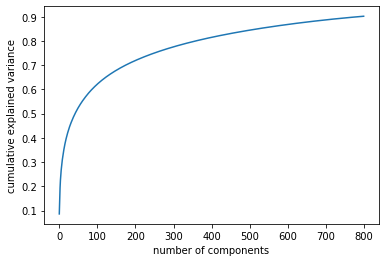

In [30]:
pca = decomposition.PCA(n_components=800)
pca.fit(QAmodel.inferst.embeddings)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
emb = pca.transform(QAmodel.inferst.embeddings)
emb

### 2) Tests of sentence embeddings models with cloud visualisation https://github.com/facebookresearch/InferSent 

In [303]:
def normalize(array):
    return array/np.linalg.norm(array)

In [72]:
MODEL_PATH = infersent_model 
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
infersent = InferSent_(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))


RuntimeError: Error(s) in loading state_dict for InferSent_:
	size mismatch for enc_lstm.weight_ih_l0: copying a param with shape torch.Size([8192, 300]) from checkpoint, the shape in current model is torch.Size([8192, 982]).
	size mismatch for enc_lstm.weight_ih_l0_reverse: copying a param with shape torch.Size([8192, 300]) from checkpoint, the shape in current model is torch.Size([8192, 982]).

In [310]:
W2V_PATH = infersent_path
dic=infersent.set_w2v_path(W2V_PATH)

In [ ]:
def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

In [49]:
infersent.build_vocab_k_words(K=200000)
#infersent.update_vocab(list(QAmodel.voc))

Vocab size : 200000


In [36]:
embeddings = infersent.encode(['chocolate', 'dance','chemicals',
                               'clothes', 'safety'
                               ,'animals', 'environment', 'risk',
                              ],
                              tokenize=True)
q_str="'hazard products.'"
question=infersent.encode([q_str])

In [38]:
q_str=pdfconverter().remove_non_alpha(q_str)
q_str=q_str.replace('.','')
q_str

'hazard products'

In [39]:
embeddings_normalized=np.apply_along_axis(lambda v: normalize(v), 1,embeddings)
question_normalized=normalize(question)

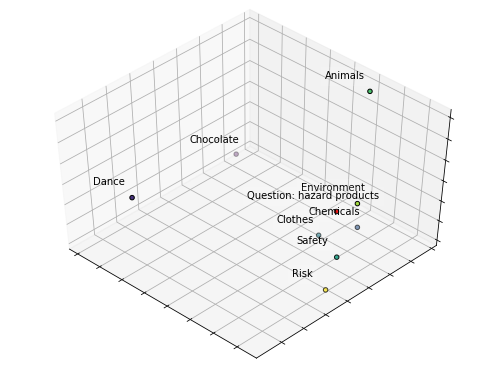

In [40]:
from sklearn import decomposition
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X =embeddings_normalized
Q=question_normalized
y=np.array(range(8))

fig = plt.figure(1, figsize=(7, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
Q=pca.transform(Q)
dic={'Chocolate':0, 'Dance':1, 'Chemicals':2,'Clothes':3,'Safety':4,'Animals':5, 'Environment':6,'Risk':7}

for name, label in dic.items():
    ax.text3D(X[y == label, 0].mean()+0.1,
              X[y == label, 1].mean(),
              X[y == label, 2].mean(),name,
              horizontalalignment='center',
              bbox=dict(alpha=.1, edgecolor='w', facecolor='w'))
    
ax.text3D(Q[0, 0].mean()+0.1,Q[0, 1].mean(),Q[0, 2].mean(),'Question: '+q_str,horizontalalignment='center',
          bbox=dict(alpha=.1, edgecolor='w', facecolor='w'))

# Reorder the labels to have colors matching the cluster results
y = np.choose(y, range(8)).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, edgecolor='k')
ax.scatter(Q[:,0],Q[:,1],Q[:,2],c='red',edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [42]:
embeddings_normalized.dot(question_normalized.T)

array([[0.6139592 ],
       [0.5630848 ],
       [0.7196866 ],
       [0.6994362 ],
       [0.70133   ],
       [0.6499989 ],
       [0.74974275],
       [0.6651032 ]], dtype=float32)

In [360]:
scores=embeddings_normalized.dot(question_normalized.T)
df=pd.DataFrame(np.c_[scores,y],columns=['scores','label']).sort_values(by=['scores'],ascending=False)
df['label']=df['label'].apply(lambda k: list(dic.keys())[list(dic.values()).index(k)])
df

,scores,label
6,0.749743,Environment
2,0.719687,Chemicals
4,0.701330,Safety
3,0.699436,Clothes
7,0.665103,Risk
5,0.649999,Animals
0,0.613959,Chocolate
1,0.563085,Dance


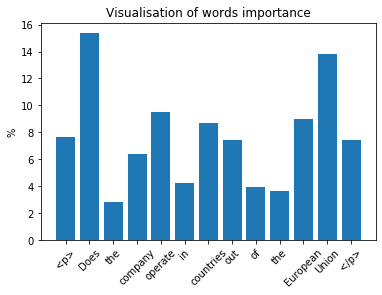

[7.6171875,
 15.380859375,
 2.8564453125,
 6.4208984375,
 9.4970703125,
 4.2724609375,
 8.6669921875,
 7.421875,
 3.9306640625,
 3.662109375,
 9.0087890625,
 13.818359375,
 7.4462890625]

In [66]:
obs=QAmodel.inferst.infersent.visualize('Does the company operate in countries out of the European Union')
obs[2]

## 3) Elastic search for fast indexing? 

## 4) Automatic Querry Generator (using Infersent word importance)

In [39]:
def generate_querry(querries):
    querries=[pdfconverter().remove_non_alpha(q) for q in querries]    
    sentences=[s[0].lower()+s[1:].replace('?','')  for s in querries]
    i=0
    important_words=[]
    unsorted_words=[]
    
    for qu in sentences:
        
        #Get scores from infersent visualization function (max-pooling et each layer)
        tensor,vector,scores,words=QAmodel.inferst.infersent.visualize(qu)
        scores=np.array(scores[1:len(scores)-1])
        words=np.array(words[1:len(words)-1])
        
        #Remove stopwords from querries and attributed scores
        pos=[i for i,c in enumerate(list(words)) if c not in QAmodel.retriever.stop_words_list]
        words=words[pos]
        scores=np.array(scores)[pos]
        scores=scores/np.sum(scores)
        
        #Sort query words by word importance keeping idx in memory to unsort it back
        data=pd.DataFrame(np.c_[words,scores],columns=['word','score'])
        idx=np.argsort(-np.array(data.score.values,dtype='float64'))
        idx_unsort=np.argsort(idx)
        data=data.sort_values(by=['score'],ascending=False)
        new_words=data.word.values
        new_scores=np.array(data.score.values,dtype=float)
        
        #Keeping a set of words that satisfy 70% of cumulative importance
        score_cum=np.cumsum(new_scores)
        pos=score_cum<0.75
        lw=new_words[pos]
        ls=new_scores[pos]
        lw_unsort=words[pos[idx]]
        
        important_words.append(lw)
        unsorted_words.append(lw_unsort)
        i+=1
    
    return pd.DataFrame(np.c_[querries, important_words,unsorted_words],columns=['query','words_sort','words_unsort'])

## Test on annual reports of top chemicals companies 

### Sources

- Useful Github pages
-  <https://github.com/UKPLab/sentence-transformers>
- < https://github.com/huggingface/pytorch-transformers>
- < https://github.com/cdqa-suite>
- Google Brain Original Paper:
- < https://nlp.stanford.edu/seminar/details/jdevlin.pdf?fbclid=IwAR2TBFCJOeZ9cGhxB-z5cJJ17vHN4W25oWsjI8NqJoTEmlYIYEKG7oh4tlY>
<  http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf>
- Tf-Idf semantic expansion
- < https://www.sciencedirect.com/science/article/pii/S1877050916311589 >


## Semantic Expansion:  Enhancement of tf-idf model with the information provided by co-occurence of terms within documents <http://www2015.wwwconference.org/documents/proceedings/companion/p805.pdf>

#### Let's start with few interestings statistics :  

###### Average document length:

In [18]:
np.mean([len(x) for x in QAmodel.content])

176.320530815363

##### Tf_iDf matrix dimension and sparsity of the matrix

In [298]:
(c,d)=(len(QAmodel.content),len(QAmodel.retriever.vectorizer.get_feature_names()))
print("(documents,vocab)=",(c,d))

(documents,vocab)= (7843, 6896)


In [299]:
T=QAmodel.retriever.tfidf_matrix
T

<7843x6896 sparse matrix of type '<class 'numpy.float64'>'
	with 111515 stored elements in Compressed Sparse Row format>

In [300]:
(a,b)=T.shape
non_zeros=100*np.sum(np.abs(T)>0)/(a*b) 
print('Tf-Idf Matrix is',100-np.round(non_zeros,2),'% sparse')

Tf-Idf Matrix is 99.79 % sparse


Two observations: 
- Each document is approximately a tweet: that's short !   
- Tf-idf matrix is a (very) sparse matrix

Idea : In this project we want to return a text chunk, among those with the highest similarities with the querry.
However Tf-Idf is bad for small document (here a document is one or two sentences). Yan et al mentioned that for short texts using tf-idf is not very efficient since term frequency in all documents is not a good
measure to capture the discriminative power of the data due to the sparsity.
Short-text segments are typically represented by very sparse
vectors, where each has non-zero weights for only a very few
terms. In this case, traditional techniques for calculating
text similarity results in measures which are very close to
zeros. This is due to the fact that documents, even the
very similar ones, do have a very few or mostly no terms in
common. In order to alleviate this limitation, we need to
enriched the representation of short-text segments by incorporating information about correlation between terms. Towards achieving this goal, we employ a method for enhancing document clustering using statistical semantics proposed by Farahat and Kamel and enhance it to handle large amounts of short documents. This is done by the following semantic kernel formula : $$K=X^{t}GX \hspace{4pt} \text{where} \hspace{4pt} G \hspace{4pt} \text{is the}\hspace{3pt} mxm \hspace{3pt} \text{term correlation matrix} \hspace{3pt} \text{and}\hspace{3pt} X^{t} \hspace{3pt} \text{is the tf-idf matrix with stemming and stopword removal} $$
$$\text{Problem : To compute the matrix} \hspace{2pt} G: \text{ the time complexity is} \hspace{2pt} O(n^2)$$
$$ \text{Solution : Factorisation method suggested by Nystrom }$$

### Term selection for correlation matrix : 

##### First we select words that have a sufficent frequency throughout documents (set to 1%)

#### We perform a random sampling of 20% of the terms using term-importance probabilities. The importance probability of a term is given by the length of his vector sparse representation inside the tf-idf matrix

In [31]:
def select_term_Naystrom(T,s=1.0):
    
    #T is the Tf-Idf Matrix 
    #s is the fraction of important words that we want to retrieve (s=1.0 generally)
    
    #Here are all the stems of tf-idf vocabulary
    terms=QAmodel.retriever.vectorizer.get_feature_names()
    
    #First we want to remove digits that are not important terms
    n=int(s*len(terms))
    idx_words=[]
    for i,term in enumerate(terms):
        try: float(term)
        except: idx_words.append(i)
   
    #Secondly we set a threshold to select words that appear at least each p documents 
    threshold=0.002 #Set threshold to select words that appear at least each p documents 
    freq_term=np.zeros((len(QAmodel.content),len(terms)))
    for j,sentence in enumerate(QAmodel.content):
        stem=QAmodel.retriever.tokenize(sentence) 
        for i,c in enumerate(terms):
            if c in stem:
                freq_term[j,i]+=1
    freq_term_by_doc=np.apply_along_axis(lambda x: np.mean(x),0,freq_term)
    ids=np.where(freq_term_by_doc>threshold)[0]
    idx_words=[ i for i in ids if i in idx_words]
    

    #Init selection of terms with most correlation 
    if s!=1.0:
        prob=np.sum(np.abs(T)>0,axis=0)
        prob=prob/np.sum(prob)
        prob=np.squeeze(prob)
        idx=[]
        m=len(idx_words)

        for i in range(n):

            p=int(np.random.choice(m,1,prob[0]))
            idx.append(int(idx_words[p]))
            prob[idx_words[p]]=0
            prob=prob/np.sum(prob)

        return idx,np.squeeze(T[:,idx])
    else:
        idx=idx_words
        return idx,np.squeeze(T[:,idx])

        

##### 1)Proceed First step

In [32]:
M=QAmodel.retriever.tfidf_matrix.toarray()
idx,A=select_term_Naystrom(M)
A.shape

(7843, 1178)

#### Visualize terms selected

In [301]:
[QAmodel.retriever.vectorizer.get_feature_names()[i] for i in idx[80:90]]

['area',
 'aris',
 'arrang',
 'articl',
 'asia',
 'ask',
 'aspect',
 'assess',
 'asset',
 'assist']

### Implementation of  Farahat - Nystrom method to compute the semantic Kernel and overcome sparcity 

Nystrom Method Explained: 

$$\text{Let} \hspace{3pt} X^T \hspace{3pt} \text{be our tf-idf matrix whose element} \hspace{3pt}X_{i,j} \hspace{3pt}\text{represents the weight of term i inside document j }$$
$$ \text{We want to express a semantic kernel K which includes the correlation between important terms and factorize it to get new sentence embeddings  } $$ $$ \text{Formally we want to approximate:}\hspace{3pt} K=X^TGX \hspace{3pt} \text{as the product: }\hspace{3pt} K\simeq W^{T}W \hspace{3pt} \text{where} \hspace{3pt} W=Z^{T}X \hspace{3pt}\ $$ $$\leftrightarrow  \hspace{3pt} \text{Equivalently : } \hspace{3pt} G=L_{X}^{-1/2}XX^{T}L_{X}^{-1/2}\hspace{5pt} \text{is approximated by}\hspace{3pt} G \simeq ZZ^{T} \hspace{4pt}  $$
The important idea is that K is a squarred matrix of document size and W is of shape (documents,term). Hence K stands as the similarity matrix between sentences and W is the sentence embedding matrix. Moreover K and W incorporate the correlation between terms provided by G. This is what we was looking for ! 
$$ \text{Such approximation for G is suggested by Nystrom in this formula} \hspace{3pt}\hat{G}=G_{:S}G_{SS}^{-1}{}G_{:S}^{T} \hspace{3pt} \text{where S is the set of selected terms}\hspace{4pt} \text{The important terms are selected given a frequency threshold.}  $$
$$ \text{Then our approximation is} \hspace{3pt} Z=G_{:S}G_{SS}^{-1/2} \hspace{3pt} \text{with G (correlation matrix)} \hspace{3pt} \text{defined as} \hspace{3pt} G=L_{X}^{-1/2}XX^{T}L_{X}^{-1/2} $$
$$ \text{It follows that } \hspace{3pt} W=Z^{T}X=(G_{:S}G_{SS}^{-1/2})^{T}X=(X_{S:}X_{S:}^{T})^{-1/2}X_{S:}X_{S:}^{T} L_{X}^{-1/2}X$$
$$ \text{We can now perform the Spherical K-means on the sentence embedding matrix } \hspace{3pt} W^T \hspace{3pt} \text{! } \hspace{3pt}  $$ Spherical K-means seeks to minimize cosine dissimilarity instead of euclidian distance.  $$ \text{Formally : } \hspace{4pt}𝐽=∑_{𝑖}𝑑(𝑥_𝑖,𝑝𝑐(𝑖)) \hspace{3pt} \text{where} \hspace{3pt} 𝑑(𝑥,𝑝)=1−𝑐𝑜𝑠(𝑥,𝑝)=\frac{⟨𝑥,𝑝⟩}{‖𝑥‖‖𝑝‖}$$
It is greatly used in NLP tasks since. One other major reason opting cosine similarity over euclidean distance will be to avoid ineffectiveness of euclidean distance when handling high dimensionality and sparse dataset. An other reason is that cosine dissimilarity doesn't account for differences of size between documents.

Enhancement of the method : We can perform a low rank SVD to compute $G_{SS}^{-1/2}$, that reduces the dimension of the semantic space to k. It makes the clustering algorithm even more efficient and reduces drastically time complexity.  We use the following SVD decomposition: $G_{SS}=UDU^T$ where $U$ is a $(k,l)$, ($k\leq l$ ) matrix which contains the k-eigen vectors associated with the k highest eigen values in the standard SVD decomposition $$ \text{Finally} \hspace{3pt} G_{SS}^{-1/2}=UD^{-1/2}U  \hspace{3pt} \text{which gives us}  \hspace{3pt}W=D^{-1/2}U^{T}X_{S:}X^TX$$

Ajout des querries dans le corpus pour la méthode de Naystrom, approximation low rank de la matrice W

In [41]:
def generate_kernel_decomposition(rank=None,subset=[]):
    if rank==None:
        rank=len(subset)
    ids=subset
    querries=data['words_sort'].tolist()
    for i,q in enumerate(querries):
        q=' '.join(list(q))
        q=q.lower()
        q=pdfconverter().remove_non_alpha(q)
        q=q.replace('.','')
        querries[i]=q
        
    qemb=QAmodel.retriever.vectorizer.transform(querries).toarray().transpose()
    X=QAmodel.retriever.tfidf_matrix.toarray().transpose()
    print(qemb.shape,X.shape)
    X=np.c_[X,qemb]
    
    L=np.eye(X.shape[0])*np.sqrt(X.shape[0])
    L_inv=np.linalg.inv(L)
    G=L_inv@X@X.transpose()@L_inv
    Gs=G[ids,:]
    Gs=Gs[:,ids]
    S,V,D=np.linalg.svd(Gs, full_matrices=True)
    Ssub,Vsub=S[:,:rank], np.diag(V)[:rank,:rank]
    #Ssub,Vsub=S,np.diag(V)
    #G=Ssub@Vsub$Ssub.transpose() but this operation is not necessary, we just need the decomposition of G
    
    D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V[:rank]))
    #D_sub_inv=np.diag(np.apply_along_axis(lambda x: 1/np.sqrt(x) , 0, V))
    W=(((D_sub_inv@Ssub.transpose())@X[ids,:])@(X.transpose()))@X
    return W
    
    


In [49]:
W=generate_kernel_decomposition(rank=500,subset=idx)

(6896, 14) (6896, 7843)


In [283]:
W.shape

(500, 7857)

In [50]:
W_=np.apply_along_axis(lambda x: x/np.sqrt(np.sum(x**2)), 1,W.transpose())
scores=W_@W_.transpose()
scores=scores[len(scores)-len(questions):,:len(scores)-len(questions)]
scores=scores[:,QAmodel.borders[2]:QAmodel.borders[3]]
scores.shape

(14, 4311)

In [358]:
W_=np.apply_along_axis(lambda x: x/np.sqrt(np.sum(x**2)), 1,W.transpose())
scores=W_@W_.transpose()
scores=scores[len(scores)-len(questions):,:len(scores)-len(questions)]
scores=scores[:,QAmodel.borders[1]:QAmodel.borders[2]]
scores.shape

(14, 3132)

# Query chunking pos tagging

In [62]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [56]:
doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('$5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [93]:
displacy.render(nlp(str(qw[10])), jupyter=True, style='ent')

/Users/williamlambert/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [94]:
displacy.render(nlp(str(qw[0][:-1]+'. '+aw[2])), jupyter=True, style='ent')

In [63]:
displacy.render(nlp('Does the company owns TOBACCO shops, COFFEE or DRINK sales OUTLET'), style='dep', jupyter = True, options = {'distance': 120})